In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.gridspec as gridspec
import sklearn.cluster as skcl
from swarmDMD_functions import *
from os import path
from scipy.optimize import curve_fit
from scipy.stats import linregress
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Loading and processing functions go here
def load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit):
    # full load data call:
    # X_GT3d,dt,v_truth,TN,X_GT,D_GT,P_GT_temp,Mang_GT_temp,Mabs_GT,mean_bin_GT,mean_bin_GT_P,X_DMD,D_DMD,P_DMD_temp,Mang_DMD_temp,Mabs_DMD,mean_bin_DMD,mean_bin_DMD_P,num_bins,bin_width,bin_freq = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
    
    if milling == 1:
        millname = '_milling'
        millnameDMD = '_milling'
        N_GT = N
    else:
        millname = '_'+str(simplified)
        millnameDMD = ''
        N_GT = N
        
    if randinit:
        randname = '_randinit'
    else:
        randname = ''
        
    filenameGT = 'vicsek'+millname+'_A'+str(N_GT)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+randname
    filenameGTAnalysis = 'vicsekAnalysis'+millnameDMD+'_'+str(simplified)+'_A'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_Focal'+str(F)+randname
    findnameDMD = 'mDMDc_datatype'+str(datatype)+'_S'+str(simplified)+'_A'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_R'+str(R)+'_Tend'+str(T_end)+'Tbeg'+str(T_beg)+'_method'+method+'_T_start'+str(T_init)+'_ReInit'+str(re_init)+'_WF'+str(waterfall)+millnameDMD+randname
    findnameDMDAnalysis = 'mDMDcAnalysis_datatype'+str(datatype)+'_S'+str(simplified)+'_A'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_R'+str(R)+'_Tend'+str(T_end)+'Tbeg'+str(T_beg)+'_Focal'+str(F)+'_method'+method+'_T_start'+str(T_init)+'_ReInit'+str(re_init)+'_WF'+str(waterfall)+millnameDMD+randname

    print(findnameDMD)
    
    try:
        filenameDMD = find_name(findnameDMD)
        filenameDMDAnalysis = find_name(findnameDMDAnalysis)
    except Exception as e: print(e)
    
    dataGT = np.load('../SwarmModel/data/ForPaper/'+filenameGT+'.npz')
    dataGTAnalysis = np.load('../SwarmModel/data/ForPaper/'+filenameGTAnalysis+'.npz')
    dataDMD = np.load('mDMDc_results/'+method+'/'+filenameDMD+'.npz')
    dataDMDAnalysis = np.load('mDMDc_results/'+method+'/'+filenameDMDAnalysis+'.npz')
    
#     if milling:
#         agent_indices = range(0,N_GT,5)
#         X_GT3d = dataGT['X'][agent_indices,:,:]
#     else:
#         X_GT3d = dataGT['X']
    X_GT3d = dataGT['X']
    dt = dataGT['dt']
    v_truth = dataGT['v']
    TN = np.shape(X_GT3d)[1]
    X_GT = np.concatenate((X_GT3d[:,:,0],X_GT3d[:,:,1]),axis=0)
    D_GT = dataGTAnalysis['D']
    P_GT = dataGTAnalysis['P']
    Mang_GT = dataGTAnalysis['Mang']
    Mabs_GT = dataGTAnalysis['Mabs']
    

    X_DMD = dataDMD['X_DMD']
    D_DMD = dataDMDAnalysis['D_DMD']
    P_DMD = dataDMDAnalysis['P_DMD']
    Mang_DMD = dataDMDAnalysis['Mang_DMD']
    Mabs_DMD = dataDMDAnalysis['Mabs_DMD']
        
    if re_init == 0:
#         if milling:
#             DMD_range = 200
#         else:
        DMD_range = TN-T_init
        print(DMD_range)
    else:
        if re_init == 1:
            super_steps = ((TN-1)-T_init)//re_init
        else:
            super_steps = (TN-T_init)//re_init
        DMD_range = re_init*super_steps 
    
    if not waterfall:
#         mean_bin_GT = dataGTAnalysis['mean_bin']
#         mean_bin_GT_P = dataGTAnalysis['mean_bin_P']
#         mean_bin_DMD = dataDMDAnalysis['mean_bin_DMD']
#         mean_bin_DMD_P = dataDMDAnalysis['mean_bin_DMD_P']
        mean_bin_GT = dataGTAnalysis['bins_percent']
        mean_bin_GT_P = dataGTAnalysis['binsP_percent']
        mean_bin_DMD = dataDMDAnalysis['bins_DMD_percent']
        mean_bin_DMD_P = dataDMDAnalysis['bins_DMDP_percent']
        num_bins = dataDMDAnalysis['num_bins']
        bin_width = dataDMDAnalysis['bin_width']
        bin_freq = dataDMDAnalysis['bin_freq']
        train_zero_count = dataGTAnalysis['training_zero_count']
        pred_zero_count = dataGTAnalysis['prediction_zero_count']
        train_zero_count_DMD = dataDMDAnalysis['training_zero_count']
        pred_zero_count_DMD = dataDMDAnalysis['prediction_zero_count']
    
        return X_GT3d[:,T_init:T_init+DMD_range,:],dt,v_truth,DMD_range,X_GT[:,T_init:T_init+DMD_range],D_GT[T_init:T_init+DMD_range],P_GT[T_init:T_init+DMD_range],Mang_GT[T_init:T_init+DMD_range],Mabs_GT[T_init:T_init+DMD_range],mean_bin_GT,mean_bin_GT_P,X_DMD,D_DMD,P_DMD,Mang_DMD,Mabs_DMD,mean_bin_DMD,mean_bin_DMD_P,num_bins,bin_width,bin_freq,train_zero_count,pred_zero_count,train_zero_count_DMD,pred_zero_count_DMD
    else:
        return X_GT3d[:,T_init:T_init+DMD_range,:],dt,v_truth,DMD_range,X_GT[:,T_init:T_init+DMD_range],D_GT[T_init:T_init+DMD_range],P_GT[T_init:T_init+DMD_range],Mang_GT[T_init:T_init+DMD_range],Mabs_GT[T_init:T_init+DMD_range],X_DMD,D_DMD,P_DMD,Mang_DMD,Mabs_DMD
    
    
def process_data(X_GT3d,dt,v_truth,TN,X_GT,D_GT,P_GT,Mang_GT,Mabs_GT,mean_bin_GT,mean_bin_GT_P,X_DMD,D_DMD,P_DMD,Mang_DMD,Mabs_DMD,mean_bin_DMD,mean_bin_DMD_P,num_bins,bin_width,bin_freq,L):
    #this doesn't need to be this big.... should do one process func per plot type I think
    X_DMD_dot = position_difference(L,X_DMD[:,:-1],X_DMD[:,1:])/dt
    speed = np.linalg.norm(np.stack((X_DMD_dot[:N,:],X_DMD_dot[N:,:]),axis=2),axis=2)
    av_speed = np.mean(speed,axis=0)

    if np.argmax((av_speed[T_end:]-v_truth)>0.005)==0:
        s_inaccurate = int(TN)
    else:
        s_inaccurate = int(T_end+np.argmax((av_speed[T_end:]-v_truth)>0.005))

    # Compare X_DMD with X
    print(np.shape(X_DMD[:,:-1]))
    print(np.shape(X_GT[:,:-1]))
    X_diff = position_difference(L,X_DMD[:,:-1], X_GT[:,:-1])

    # Average absolute value of error
    X_avgabsx = np.mean(np.absolute(X_diff[0:N,:]),axis=0)
    X_avgabsy = np.mean(np.absolute(X_diff[N:2*N,:]),axis=0)
    X_stdx = np.std(np.absolute(X_diff[0:N,:]),axis=0)
    X_stdy = np.std(np.absolute(X_diff[N:2*N,:]),axis=0)
    Xx_avgprior = np.mean(X_avgabsx[T_beg:T_end])
    Xy_avgprior = np.mean(X_avgabsy[T_beg:T_end])

    dist_bound = 0.25

    if np.argmax(X_avgabsx[T_end:]>dist_bound) == 0:
        if np.max(X_avgabsx[T_end:]>dist_bound) == 0:
            Xx_inaccurate = int(TN)
        else:
            Xx_inaccurate = int(T_end)
    else:
        Xx_inaccurate = int(T_end+np.argmax(X_avgabsx[T_end:]>dist_bound))

    if np.argmax(X_avgabsy[T_end:]>dist_bound)==0:
        if np.max(X_avgabsy[T_end:]>dist_bound)==0:
            Xy_inaccurate = int(TN)
        else:
            Xy_inaccurate = int(T_end)
    else:
        Xy_inaccurate = int(T_end+np.argmax(X_avgabsy[T_end:]>dist_bound))

    percent_error = 0.1
    
    if np.max(((av_speed[T_end:]-v_truth)/v_truth)>0.1) == 0:
        s_err = TN
    else:
        s_err = T_end + np.argmax(((av_speed[T_end:]-v_truth)/v_truth)>0.1)
        
    bin_x_plot,bin_y_plot = np.meshgrid(np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1),np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1))


    # norm of difference of density
    try:
        density_diff = np.around(100*(np.linalg.norm(mean_bin_GT-mean_bin_DMD))/np.linalg.norm(mean_bin_GT),decimals=5)
        print('if an error shows up, it is okay if '+str(T_init)+' is bigger than '+str(T_end))
    except Exception as e:
        print(e)
    density_diff_P = np.around(100*(np.linalg.norm(mean_bin_GT_P-mean_bin_DMD_P))/np.linalg.norm(mean_bin_GT_P),decimals=5)
    return speed, av_speed,s_err,s_inaccurate,X_avgabsx,X_avgabsy,Xx_avgprior,Xy_avgprior,dist_bound,Xx_inaccurate,Xy_inaccurate,density_diff,density_diff_P,X_diff, bin_x_plot,bin_y_plot,X_stdx,X_stdy

def ProcessData_StandardErrors(X_GT,X_DMD,L):
    X_diff = position_difference(L,X_DMD[:,:-1], X_GT[:,:-1])

    # Average absolute value of error
    X_avgabsx = np.mean(np.absolute(X_diff[0:N,:]),axis=0)
    X_avgabsy = np.mean(np.absolute(X_diff[N:2*N,:]),axis=0)
    print(np.shape(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2)))
    Pos_err = np.mean(np.linalg.norm(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2),axis=2),axis=0)
    
    return X_avgabsx, X_avgabsy, Pos_err

def recentre_milling(X_DMD,X_GT,x_offset,y_offset):
    X_DMD_new = np.zeros(np.shape(X_DMD))
    X_GT_new = np.zeros(np.shape(X_GT))
    for t in range(TN):
        x_dmd = np.concatenate([X_DMD[:N,t]+x_offset,X_DMD[N:,t]+y_offset],axis=0)
        x_gt = np.concatenate([X_GT[:N,t]+x_offset,X_GT[N:,t]+y_offset],axis=0)

        boundaryT_index = np.where(x_dmd>L)
        boundaryB_index = np.where(x_dmd<0)

        x_dmd[boundaryT_index] = x_dmd[boundaryT_index] - L*(x_dmd[boundaryT_index]//L)
        x_dmd[boundaryB_index] = x_dmd[boundaryB_index] - L*(x_dmd[boundaryB_index]//L)

        boundaryT_index = np.where(x_gt>L)
        boundaryB_index = np.where(x_gt<0)

        x_gt[boundaryT_index] = x_gt[boundaryT_index] - L*(x_gt[boundaryT_index]//L)
        x_gt[boundaryB_index] = x_gt[boundaryB_index] - L*(x_gt[boundaryB_index]//L)

        # Check bounds obeyed
        boundaryT_index = np.where(x_dmd>L)
        boundaryB_index = np.where(x_dmd<0)

        X_DMD_new[:,t] = x_dmd
        X_GT_new[:,t] = x_gt
    return X_DMD_new, X_GT_new

In [20]:
# Plotting functions go here
def plot_errs(dt,iterates,iterate_labels,N,T_beg,X_avgabsx,X_avgabsy,P_GT,P_DMD,Mang_GT,Mang_DMD):
    T_stop = np.shape(P_GT)[0]+T_beg
    T_start = T_beg
    time = np.linspace(dt*T_start,dt*T_stop,np.shape(P_GT)[0])
    
    linetypes = ['solid','dashdot','dashed','dotted',(0,(3,1,1,1,1,1)),(0,(1,1))]
    
    fig = plt.figure(figsize=(6,6))
    grid = plt.GridSpec(2, 2, figure=fig, hspace=0.15, wspace=0.3)

    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[0,1])
    ax3 = fig.add_subplot(grid[1,0])
    ax4 = fig.add_subplot(grid[1,1])

    plt.set_cmap('Pastel1')
    ax1.set_ylabel(r"$e_x$",fontsize=18)
    for j in range(len(iterates)):
        ax1.semilogy(time,X_avgabsx[:,j]/iterates[j],label=iterate_labels[j],linestyle=linetypes[j])
    ax1.grid()
    ax1.set_ylim(bottom=1E-4,top=1E1)
    ax1.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    
    plt.set_cmap('Pastel1')
    ax2.set_ylabel(r"$e_y$",fontsize=18)
    for j in range(len(iterates)):
        ax2.semilogy(time,X_avgabsy[:,j]/iterates[j],label=iterate_labels[j],linestyle=linetypes[j])
    ax2.grid()
    ax2.set_ylim(bottom=1E-4,top=1E1)
    ax2.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_yticklabels([])
    
    plt.set_cmap('Pastel1')
    ax3.set_ylabel(r"$e_P$",fontsize=18)
    for j in range(len(iterates)):
        ax3.semilogy(time,np.absolute(P_GT[:,j]-P_DMD[:,j]),label=iterate_labels[j],linestyle=linetypes[j])
    ax3.grid()
    ax3.set_ylim(bottom=1E-4,top=1E1)
    ax3.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax3.tick_params(axis='x', labelsize=12)
    ax3.tick_params(axis='y', labelsize=12)
    ax3.set_xlabel('Time (s)',fontsize=14)
    
    plt.set_cmap('Pastel1')
    ax4.set_ylabel(r"$e_{M}$",fontsize=18)
    for j in range(len(iterates)):
        ax4.semilogy(time,np.absolute(Mang_GT[:,j]-Mang_DMD[:,j]),label=iterate_labels[j],linestyle=linetypes[j])
    ax4.grid()
    ax4.set_ylim(bottom=1E-4,top=1E1)
    ax4.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax4.tick_params(axis='x', labelsize=12)
    ax4.tick_params(axis='y', labelsize=12)
    ax4.set_yticklabels([])
    
    ax2.legend(title="Interaction Radius",bbox_to_anchor=(1.05, 1.02), loc='upper left',fontsize=14,title_fontsize=15)
    
    return fig


def plot_errPM(dt,iterates,iterate_labels,N,T_beg,P_GT,P_DMD,Mang_GT,Mang_DMD,vert_bars):
    T_stop = np.shape(P_GT)[0]+T_beg
    T_start = T_beg
    time = np.linspace(dt*T_start,dt*T_stop,np.shape(P_GT)[0])
    ticklabels = np.arange(0,dt*T_stop+1,5)
    
    linetypes = ['solid','dashdot','dashed','dotted',(0,(3,1,1,1,1,1)),(0,(1,1))]
    
#     fig = plt.figure(figsize=(5*len(vert_bars),3))
#     grid = plt.GridSpec(2, 2, figure=fig, hspace=0.15, wspace=0.3)

#     ax1 = fig.add_subplot(grid[0,:])
#     ax2 = fig.add_subplot(grid[1,:])
    
    fig = plt.figure(figsize=(3*len(vert_bars),3))
    grid = plt.GridSpec(2, 1, figure=fig, hspace=0.15, wspace=0.3)

    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[1,0])
    
    plt.set_cmap('Pastel1')
    ax1.set_ylabel(r"$e_P$",fontsize=20)
    for i in range(len(vert_bars)):
        ax1.axvline(x=dt*vert_bars[i],color='firebrick',linestyle='dashed',linewidth=2.0)
    for j in range(len(iterates)):
        ax1.semilogy(time,np.absolute(P_GT[:,j]-P_DMD[:,j]),label=iterate_labels[j],linestyle=linetypes[j])
    ax1.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
    ax1.grid()
    ax1.set_ylim(bottom=1E-5,top=1E0)
    ax1.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax1.tick_params(axis='both', labelsize=16)
    ax1.set_xticklabels([])
    ax1.set_xticks(ticklabels)
    ax1.set_yticks(np.logspace(-5,0,5))
    
    plt.set_cmap('Pastel1')
    ax2.set_ylabel(r"$e_{M}$",fontsize=20)
    for i in range(len(vert_bars)):
        ax2.axvline(x=dt*vert_bars[i],color='firebrick',linestyle='dashed',linewidth=2.0)
    for j in range(len(iterates)):
        ax2.semilogy(time,np.absolute(Mang_GT[:,j]-Mang_DMD[:,j]),label=iterate_labels[j],linestyle=linetypes[j])
    ax2.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
    ax2.grid()
    ax2.set_ylim(bottom=1E-5,top=1E0)
    ax2.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax2.tick_params(axis='both', labelsize=16)
#     ax2.set_xlabel('Time (s)',fontsize=18)
    ax2.set_yticks(np.logspace(-5,0,5))
    ax2.set_xticks(ticklabels)
    
#     ax2.legend(title="",bbox_to_anchor=(1.05, 1.02), loc='upper left',fontsize=15,title_fontsize=15)
#     ax2.legend(loc='lower right',fontsize=15,ncol=len(iterates),borderpad=0.2, labelspacing=0.3)
    
    return fig

def plot_PosErrs(dt,iterates,iterate_labels,N,T_beg,x_err,y_err,h_err,pos_errs,vert_bars):
    T_stop = np.shape(P_GT)[0]+T_beg
    T_start = T_beg
    time = np.linspace(dt*T_start,dt*T_stop,np.shape(P_GT)[0])
    ticklabels = np.arange(0,dt*T_stop+1,5)
    
    linetypes = ['solid','dashdot','dashed','dotted',(0,(3,1,1,1,1,1)),(0,(1,1))]
    
#     fig = plt.figure(figsize=(5*len(vert_bars),3))
#     grid = plt.GridSpec(3, 2, figure=fig, hspace=0.15, wspace=0.3)

#     ax1 = fig.add_subplot(grid[0,0:1])
#     ax2 = fig.add_subplot(grid[1,0:1])
#     ax3 = fig.add_subplot(grid[2,0:1])

#     plt.set_cmap('Pastel1')
#     ax1.set_ylabel(r"$e_x$",fontsize=18)
#     for i in range(len(vert_bars)):
#         ax1.axvline(x=dt*vert_bars[i],color='r',linestyle='dashed',linewidth=2.0)
#     for j in range(len(iterates)):
#         ax1.semilogy(time,x_err[:,j],label=iterate_labels[j],linestyle=linetypes[j])
#     ax1.grid()
#     ax1.set_ylim(bottom=1E-7,top=1E1)
#     ax1.set_xlim(left=dt*T_start,right=dt*T_stop)
#     ax1.tick_params(axis='x', labelsize=12)
#     ax1.tick_params(axis='y', labelsize=12)
#     ax1.set_xticklabels([])
    
#     plt.set_cmap('Pastel1')
#     ax2.set_ylabel(r"$e_y$",fontsize=18)
#     for i in range(len(vert_bars)):
#         ax2.axvline(x=dt*vert_bars[i],color='r',linestyle='dashed',linewidth=2.0)
#     for j in range(len(iterates)):
#         ax2.semilogy(time,y_err[:,j],label=iterate_labels[j],linestyle=linetypes[j])
#     ax2.grid()
#     ax2.set_ylim(bottom=1E-7,top=1E1)
#     ax2.set_xlim(left=dt*T_start,right=dt*T_stop)
#     ax2.tick_params(axis='x', labelsize=12)
#     ax2.tick_params(axis='y', labelsize=12)
#     ax2.set_xticklabels([])

    fig = plt.figure(figsize=(3*len(vert_bars),3))
    grid = plt.GridSpec(2, 1, figure=fig, hspace=0.15, wspace=0.3)

    ax2 = fig.add_subplot(grid[0,0])
    ax3 = fig.add_subplot(grid[1,0])
    
    plt.set_cmap('Pastel1')
    ax2.set_ylabel(r"$e_x$",fontsize=20)
    for i in range(len(vert_bars)):
        ax2.axvline(x=dt*vert_bars[i],color='firebrick',linestyle='dashed',linewidth=2.0)
    for j in range(len(iterates)):
        ax2.semilogy(time,pos_errs[:,j],label=iterate_labels[j],linestyle=linetypes[j])
    ax2.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
    ax2.grid()
    ax2.set_ylim(bottom=1E-5,top=1E1)
#     ax2.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax2.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax2.tick_params(axis='both', labelsize=16)
    ax2.set_xticklabels([])
    ax2.set_xticks(ticklabels)
    ax2.set_yticks(np.logspace(-5,1,6))
    
    plt.set_cmap('Pastel1')
    ax3.set_ylabel(r"$e_\theta$",fontsize=20)
    for i in range(len(vert_bars)):
        ax3.axvline(x=dt*vert_bars[i],color='firebrick',linestyle='dashed',linewidth=2.0)
    for j in range(len(iterates)):
        ax3.semilogy(time,h_err[:,j],label=iterate_labels[j],linestyle=linetypes[j])
    ax3.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
    ax3.grid()
#     ax3.grid(which='minor', linestyle=':',axis='y',color='g')
    ax3.set_ylim(bottom=1E-5,top=1E1)
#     ax3.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax3.set_xlim(left=dt*T_start,right=dt*T_stop)
    ax3.tick_params(axis='both', labelsize=16)
    ax3.set_xlabel('Time (s)',fontsize=18)
    ax3.set_yticks(np.logspace(-5,1,6))
    ax3.set_xticks(ticklabels)
    
#     ax2.legend(title="",bbox_to_anchor=(1.05, 1.02), loc='upper left',fontsize=15,title_fontsize=15)
    
    if iterate_labels[0]:
        ax3.legend(loc='lower right',fontsize=15,ncol=len(iterates),borderpad=0.2, labelspacing=0.3)
    
    return fig

def plot_agents(X_GT,X_DMD,N,L,vert_bars,dt):
    num_plots = np.shape(X_GT)[1]
    num_datasets = np.shape(X_DMD)[2]
    fig = plt.figure(figsize=(3*len(vert_bars),2.8))
    grid = plt.GridSpec(1, num_plots, figure=fig, hspace=0.15, wspace=0.3)
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    ax = {}
    for i in range(num_plots):
        ax[str(i)] = fig.add_subplot(grid[0,i])
#     ax2 = fig.add_subplot(grid[0,1])
#     ax3 = fig.add_subplot(grid[0,2])
    
    for i in range(num_plots):
        plt.set_cmap('Pastel1')
        ax[str(i)].plot([X_GT[:N,i],X_DMD[:N,i,num_datasets-1]],[X_GT[N:,i],X_DMD[N:,i,num_datasets-1]],marker=None,color='lightgrey',linewidth=3,zorder=-1)
        ax[str(i)].scatter(X_GT[:N,i],X_GT[N:,i],c='lightgrey',s=60)
        for j in range(num_datasets):
            ax[str(i)].scatter(X_DMD[:N,i,j],X_DMD[N:,i,j],c=colours[j],zorder=3,s=60)
        ax[str(i)].set_xlim(left=0,right=L)
        ax[str(i)].set_ylim(bottom=0,top=L)
        ax[str(i)].tick_params(axis='both', labelsize=16)
        ax[str(i)].text(0+0.1, L-0.2, r"$t={0}$".format(np.round(dt*vert_bars[i],decimals=3)), style='italic',fontsize=18 ,
        bbox={'facecolor': 'dimgrey', 'alpha': 0.5, 'pad': 5})
        
    
    return fig 

def plot_agents_tails(X_GT,X_DMD,N,L,vert_bars,dt,rs_used):
#     num_plots = np.shape(X_GT)[1]
    r_legend = {'0.05':0,'0.25': 1, '0.5': 2,'1':4}
    tail_length = vert_bars[1]-vert_bars[0]
    print(tail_length)
    num_plots = len(vert_bars)
    num_datasets = np.shape(X_DMD)[2]
    print(num_datasets)
    fig = plt.figure(figsize=(3*len(vert_bars),2.8))
    grid = plt.GridSpec(1, num_plots, figure=fig, hspace=0.15, wspace=0.15)
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    coloursGT = ['lightskyblue','bisque','lightgreen','','thistle']
    
    ax = {}
    for i in range(num_plots):
        ax[str(i)] = fig.add_subplot(grid[0,i])
#     ax2 = fig.add_subplot(grid[0,1])
#     ax3 = fig.add_subplot(grid[0,2])
    
    for i in range(num_plots):
        plt.set_cmap('Pastel1')
        for j in range(num_datasets):
            ax[str(i)].scatter(X_GT[:N,vert_bars[i],j],X_GT[N:,vert_bars[i],j],c=coloursGT[r_legend[str(rs_used[j])]],s=30,zorder=4+j,alpha=1,linewidths=0.75,edgecolor='dimgrey',marker="P")
            ax[str(i)].plot(X_DMD[:N,vert_bars[i]:vert_bars[i]+tail_length,j].T,X_DMD[N:,vert_bars[i]:vert_bars[i]+tail_length,j].T,zorder=-1,c=colours[r_legend[str(rs_used[j])]],linestyle='',marker='o',markersize=2)
            ax[str(i)].plot(X_GT[:N,vert_bars[i]:vert_bars[i]+tail_length,j].T,X_GT[N:,vert_bars[i]:vert_bars[i]+tail_length,j].T,zorder=-2,c='dimgrey',linestyle='',marker='o',markersize=2,alpha=0.6)
            ax[str(i)].scatter(X_DMD[:N,vert_bars[i],j],X_DMD[N:,vert_bars[i],j],c=colours[r_legend[str(rs_used[j])]],s=40,zorder=j,edgecolor='k')
        
        if not milling:
            ax[str(i)].set_xlim(left=0,right=L)
            ax[str(i)].set_ylim(bottom=0,top=L)
            ax[str(i)].text(0+0.02, -0.2, r"$t\in[{start},{stop})$".format(start=np.round(dt*vert_bars[i],decimals=3),stop=np.round(dt*vert_bars[i]+5,decimals=3)), style='italic',fontsize=14 ,
            bbox={'facecolor': 'dimgrey', 'alpha': 0, 'pad': 5})
        else:
            ax[str(i)].set_xlim(left=(L/2)-5,right=(L/2)+5)
            ax[str(i)].set_ylim(bottom=(L/2)-5,top=(L/2)+5)
            ax[str(i)].text((L/2)-5+0.02, (L/2)-5-1.2, r"$t\in[{start},{stop})$".format(start=np.round(dt*vert_bars[i],decimals=3),stop=np.round(dt*vert_bars[i]+5,decimals=3)), style='italic',fontsize=14 ,
            bbox={'facecolor': 'dimgrey', 'alpha': 0, 'pad': 5})
        if True: #i>0:
#             ax[str(i)].set_yticklabels([])
            ax[str(i)].xaxis.set_visible(False)
            ax[str(i)].yaxis.set_visible(False)
            
        ax[str(i)].tick_params(axis='both', labelsize=16)
        
    
    return fig 
    

In [22]:
# Parameters
N = 50 # number of agents
F = 50 # number of agents for density plots
R = 8 # DMD modes used
dt = 0.1 # time step
# TN = 800 # milling
TN = 300
milling = 0
randinit = 0

etas = [0,np.pi/12] 
eta = etas[0]
# eta = 0.08726646259971647 # milling
eta_name = str(eta).replace('.','')

rho = 16 # density
# rho = 2.5 # milling
wide = 0 # to make domain wider than initial condition
if wide:
    L0 = np.sqrt(N/rho) # length of domain of agent initial positions
    L = 6*L0 # length of domain square side 
else:
    if milling:
        L0 = np.sqrt(1000/rho)
    else:
        L0 = np.sqrt(N/rho)
    L = L0

A = L0**2
r_av = (1/(N/A))**(1/2)

rs = [0.2*r_av,r_av,2*r_av] #20%, 100%, and 200% of r_av
# rs = [1] # milling
r = rs[0]
r_name = str(r).replace('.','')

# Simulation settings and names
simplified = 0
gif = 1

# datatype = [13,20,21]
# methods = ['simple', 'FO_cartesian','FO_polar']
datatype = 13
method = 'simple'
if milling == 1:
    millname = '_milling'
else:
    millname = ''
if randinit:
    randname = '_randinit'
else:
    randname = ''

T_beg = 0 # training period beginning
T_end = 50 # training period end
T_init = 0 # time step where DMD initial positions were initialised
re_init = 0
waterfall = 0
T_pred = 50 

if re_init == 0:
    DMD_range = TN-T_init-1
else:
    super_steps = (TN-T_init)//re_init
    DMD_range = re_init*super_steps-1

In [21]:
a = np.array([[0,3,2,4],[1,2,3,4]])
b = np.array([[6,5,0,1],[2,0,1,6]])
np.minimum(a,b)

array([[0, 3, 0, 1],
       [1, 0, 1, 4]])

In [23]:
h_diff = np.absolute(X_DMD_heading[:,T_start:T_stop-1]-X_GT_heading[:,T_start:T_stop-1]) 
h_err = np.minimum(h_diff, 2*np.pi - h_diff)
h_err

array([[8.76462138e-07, 3.09231925e-06, 9.35681762e-06, ...,
        1.10000567e-05, 1.10000562e-05, 1.10000550e-05],
       [1.97150287e-08, 2.89643425e-06, 3.04251683e-06, ...,
        2.71893776e-05, 2.71893746e-05, 2.71893718e-05],
       [2.70479214e-06, 8.19233067e-06, 3.22004675e-05, ...,
        1.09627815e-05, 1.09627732e-05, 1.09627659e-05],
       ...,
       [6.32045021e-06, 5.24629204e-06, 2.10434235e-05, ...,
        8.31849827e-05, 8.31849742e-05, 8.31849673e-05],
       [3.97611646e-07, 4.41916800e-07, 5.55802119e-06, ...,
        1.60389970e-05, 1.60390012e-05, 1.60390043e-05],
       [1.20163754e-06, 5.29801020e-06, 2.31738357e-05, ...,
        1.90869138e-05, 1.90869161e-05, 1.90869175e-05]])

[ 0 50]
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 99, 2)
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 99, 2)
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 99, 2)


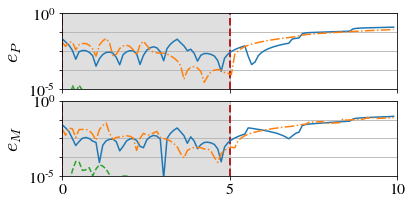

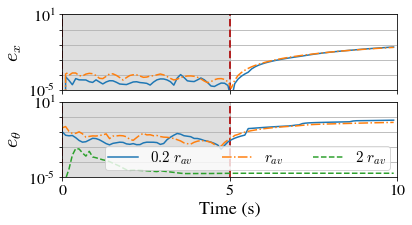

In [24]:
# Standard Error Plots - training
iterates = rs
# iterates = [r_av]
iterate_labels = [r'$0.2 \ r_{av}$',r'$r_{av}$', r'$2 \ r_{av}$']
# iterate_labels = ['']
T_start = 0
T_stop = 100
vert_bars = np.linspace(T_start,T_stop,3,dtype=int)[:-1]
print(vert_bars)

P_GT = np.zeros((T_stop-T_start-1,np.size(iterates)))
Mang_GT = np.zeros((T_stop-T_start-1,np.size(iterates)))
P_DMD = np.zeros((T_stop-T_start-1,np.size(iterates)))
Mang_DMD = np.zeros((T_stop-T_start-1,np.size(iterates)))
X_avgabsx = np.zeros((T_stop-T_start-1,np.size(iterates)))
X_avgabsy = np.zeros((T_stop-T_start-1,np.size(iterates)))
pos_errs = np.zeros((T_stop-T_start-1,np.size(iterates)))
h_errs = np.zeros((T_stop-T_start-1,np.size(iterates)))

j = 0
for r in rs:
    r_name = str(r).replace('.','')
    _,dt,_,TN,X_GT,_,P_GT_temp,Mang_GT_temp,_,_,_,X_DMD,_,P_DMD_temp,Mang_DMD_temp,_,_,_,_,_,_,_,_,_,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
    X_avgabsx[:,j],X_avgabsy[:,j], pos_errs[:,j] = ProcessData_StandardErrors(X_GT[:,T_start:T_stop],X_DMD[:,T_start:T_stop],L)
    P_GT[:,j] = P_GT_temp[T_start:T_stop-1]
    Mang_GT[:,j] = Mang_GT_temp[T_start:T_stop-1]
    P_DMD[:,j] = P_DMD_temp[T_start:T_stop-1]
    Mang_DMD[:,j] = Mang_DMD_temp[T_start:T_stop-1]
    
    X_DMD_dot = position_difference(L,X_DMD[:,:-1],X_DMD[:,1:])/dt
    X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])
    X_GT_dot = position_difference(L,X_GT[:,:-1],X_GT[:,1:])/dt
    X_GT_heading = np.arctan2(X_GT_dot[N:,:],X_GT_dot[:N,:])
    h_diff = np.absolute(X_DMD_heading[:,T_start:T_stop-1]-X_GT_heading[:,T_start:T_stop-1])
    h_errs[:,j] = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)
    
    j = j+1
    
# DTfig = plottingDT(dt,iterates,iterate_labels,N,T_start,X_avgabsx[T_start:T_stop,:],X_avgabsy[T_start:T_stop,:],P_GT[T_start:T_stop,:],P_DMD[T_start:T_stop,:],Mang_GT[T_start:T_stop,:],Mang_DMD[T_start:T_stop,:])
# DTfig = plot_errs(dt,iterates,iterate_labels,N,T_start,X_avgabsx,X_avgabsy,P_GT,P_DMD,Mang_GT,Mang_DMD)
# DTfig.savefig('Figures/ForPaper/Errorcomp'+'_eta'+eta_name+'_method'+method+'_Tstart'+str(T_start)+'_Tstop'+str(T_stop), dpi=150,bbox_inches='tight')

PMfig = plot_errPM(dt,iterates,iterate_labels,N,T_start,P_GT,P_DMD,Mang_GT,Mang_DMD,vert_bars)
# PMfig.savefig('Figures/ForPaper/PMerrorcomp'+millname+'_eta'+eta_name+'_method'+method+'_Tstart'+str(T_start)+'_Tstop'+str(T_stop)+randname, dpi=150,bbox_inches='tight')
PosErrsfig = plot_PosErrs(dt,iterates,iterate_labels,N,T_start,X_avgabsx,X_avgabsy,h_errs,pos_errs,vert_bars)
# PosErrsfig.savefig('Figures/ForPaper/Poserrorcomp'+millname+'_eta'+eta_name+'_method'+method+'_Tstart'+str(T_start)+'_Tstop'+str(T_stop)+randname, dpi=150,bbox_inches='tight')

mDMDc_datatype13_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
50
1


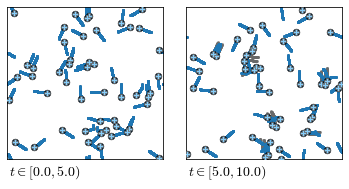

In [25]:
# Agent plots 
# rs_used = [r_av]
rs_used = [rs[0]]
# rs_used = [1]
T_start = 0
T_stop = 100
vert_bars = np.linspace(T_start,T_stop,3,dtype=int)[:-1]
X_GT = np.zeros((2*N,len(vert_bars)))
X_DMD = np.zeros((2*N,len(vert_bars),len(rs_used)))
X_GT_tail = np.zeros((2*N,(T_stop-T_start)+1,len(rs_used)))
X_DMD_tail = np.zeros((2*N,(T_stop-T_start)+1,len(rs_used)))


i=0
# for r in rs:
for r in rs_used:
    r_name = str(r).replace('.','')
    _,dt,_,TN,X_GT_temp,_,_,_,_,_,_,X_DMD_temp,_,_,_,_,_,_,_,_,_,_,_,_,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
    if milling:
        X_DMD_temp, X_GT_temp = recentre_milling(X_DMD_temp,X_GT_temp,8,3)
    X_GT = X_GT_temp[:,vert_bars]
    X_DMD[:,:,i] = X_DMD_temp[:,vert_bars]
    X_GT_tail[:,:,i] = X_GT_temp[:,:(T_stop-T_start)+1]
    X_DMD_tail[:,:,i] = np.copy(X_DMD_temp[:,:(T_stop-T_start)+1])
    i=i+1
    
agent_plots = plot_agents_tails(X_GT_tail,X_DMD_tail,N,L,vert_bars,dt,rs_used)
agent_plots.savefig('Figures/ForPaper/AgentPositions'+millname+'_eta'+eta_name+'_r'+r_name+'_method'+method+'_Tstart'+str(T_start)+'_Tstop'+str(T_stop)+randname, dpi=150,bbox_inches='tight')

In [13]:
print(np.shape(X_DMD_tail))

(100, 101, 3)


mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300


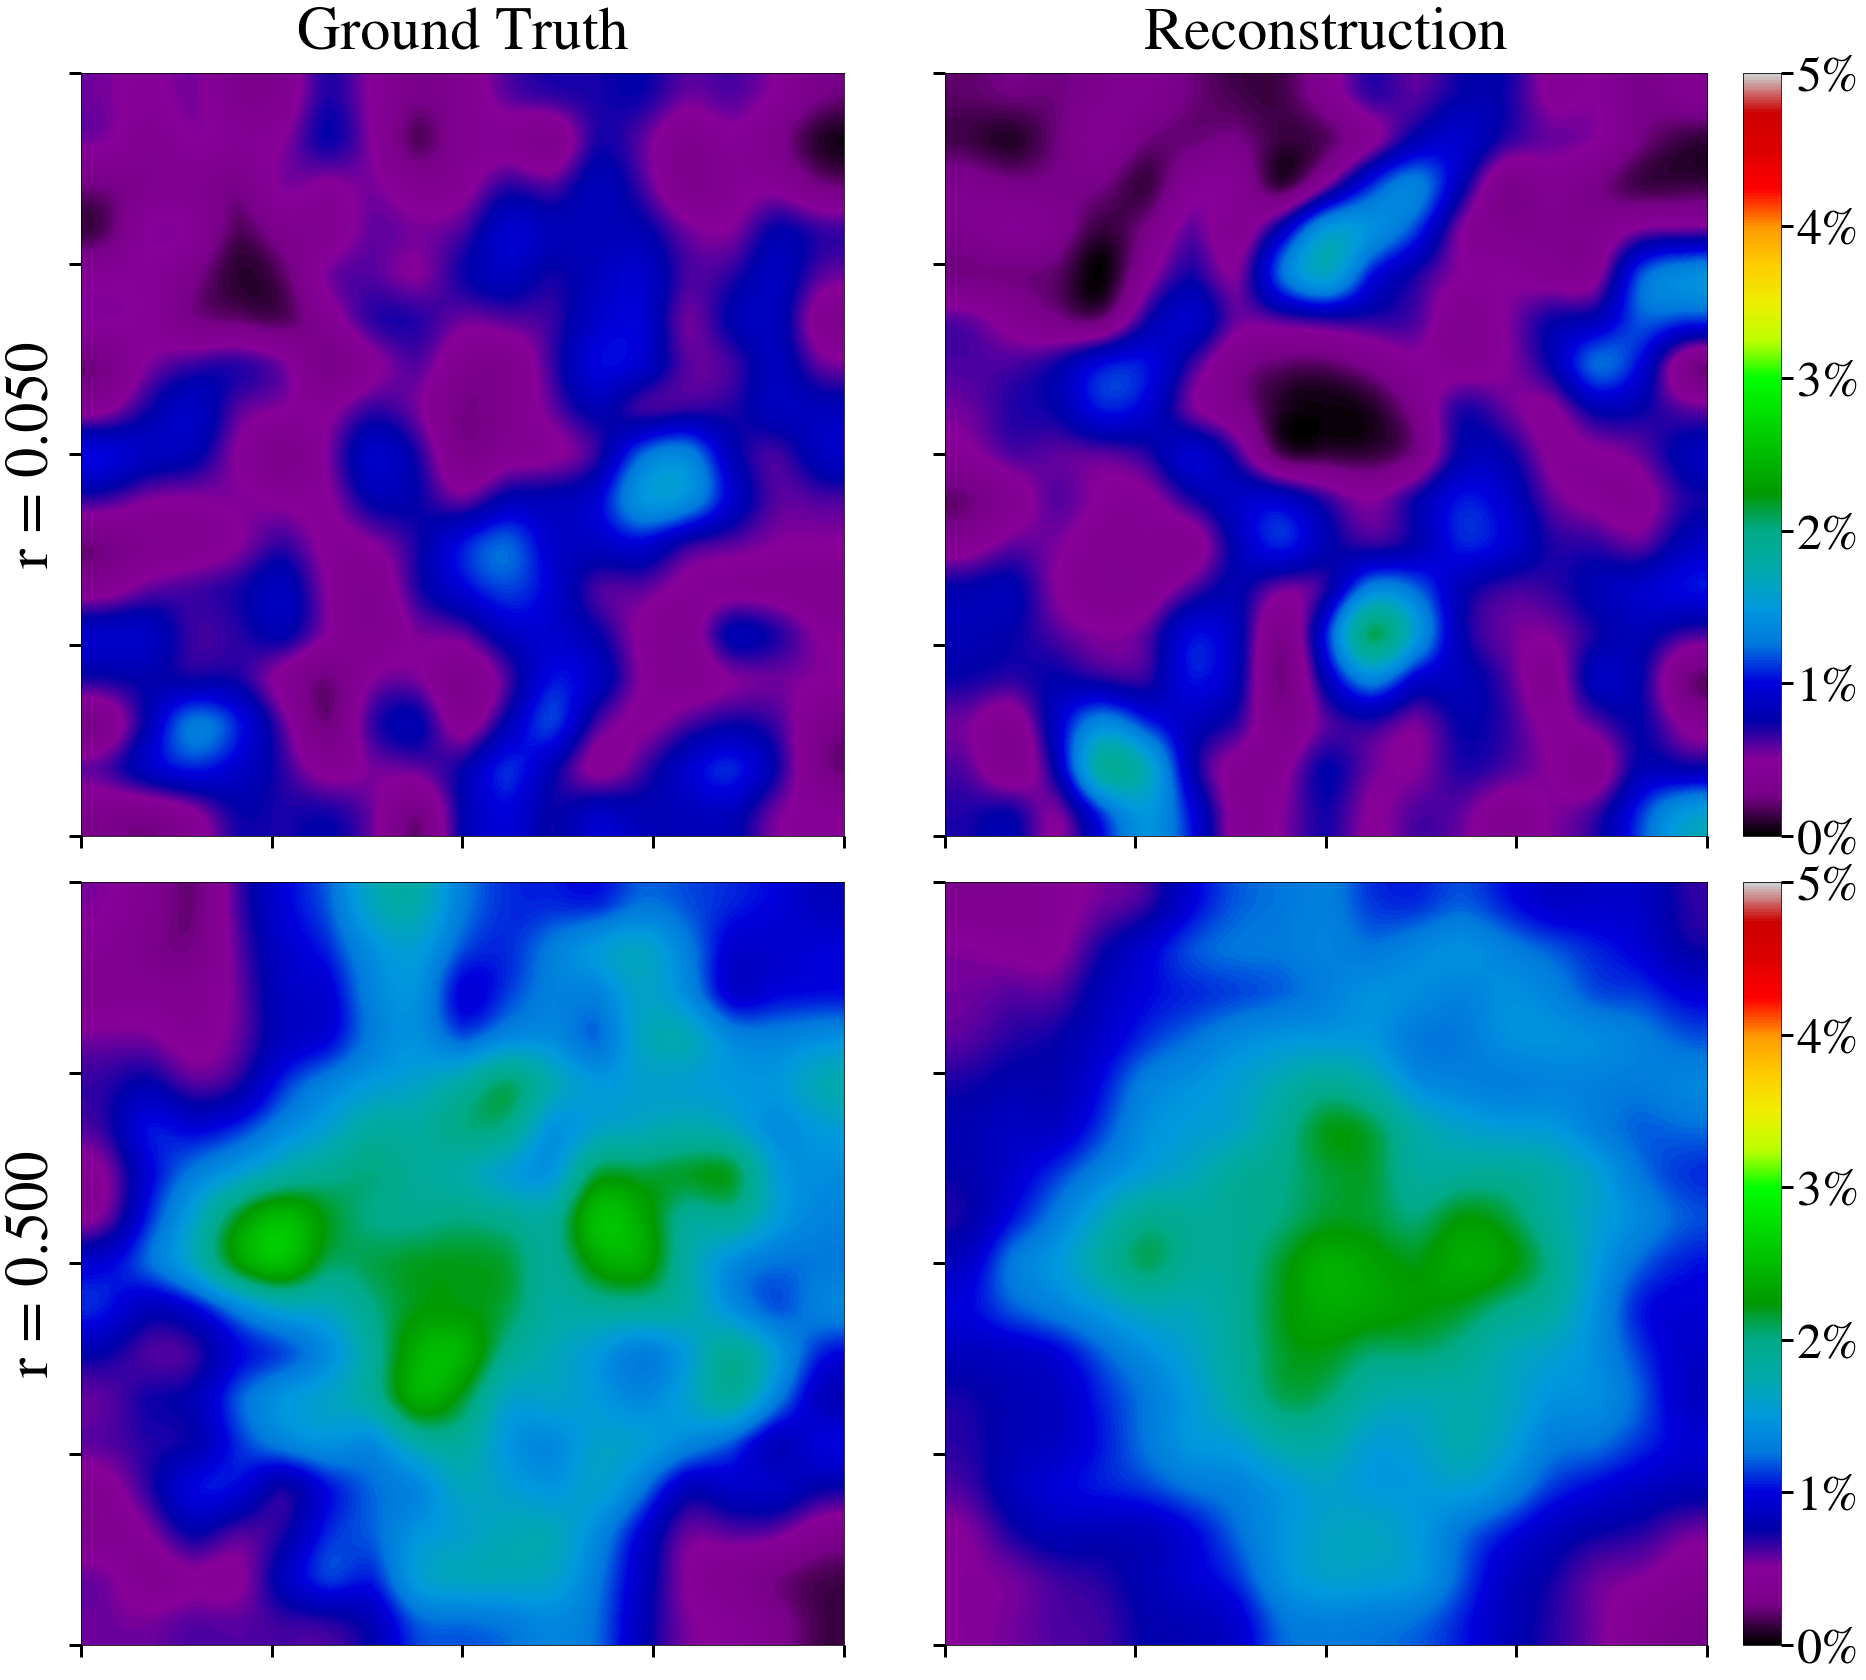

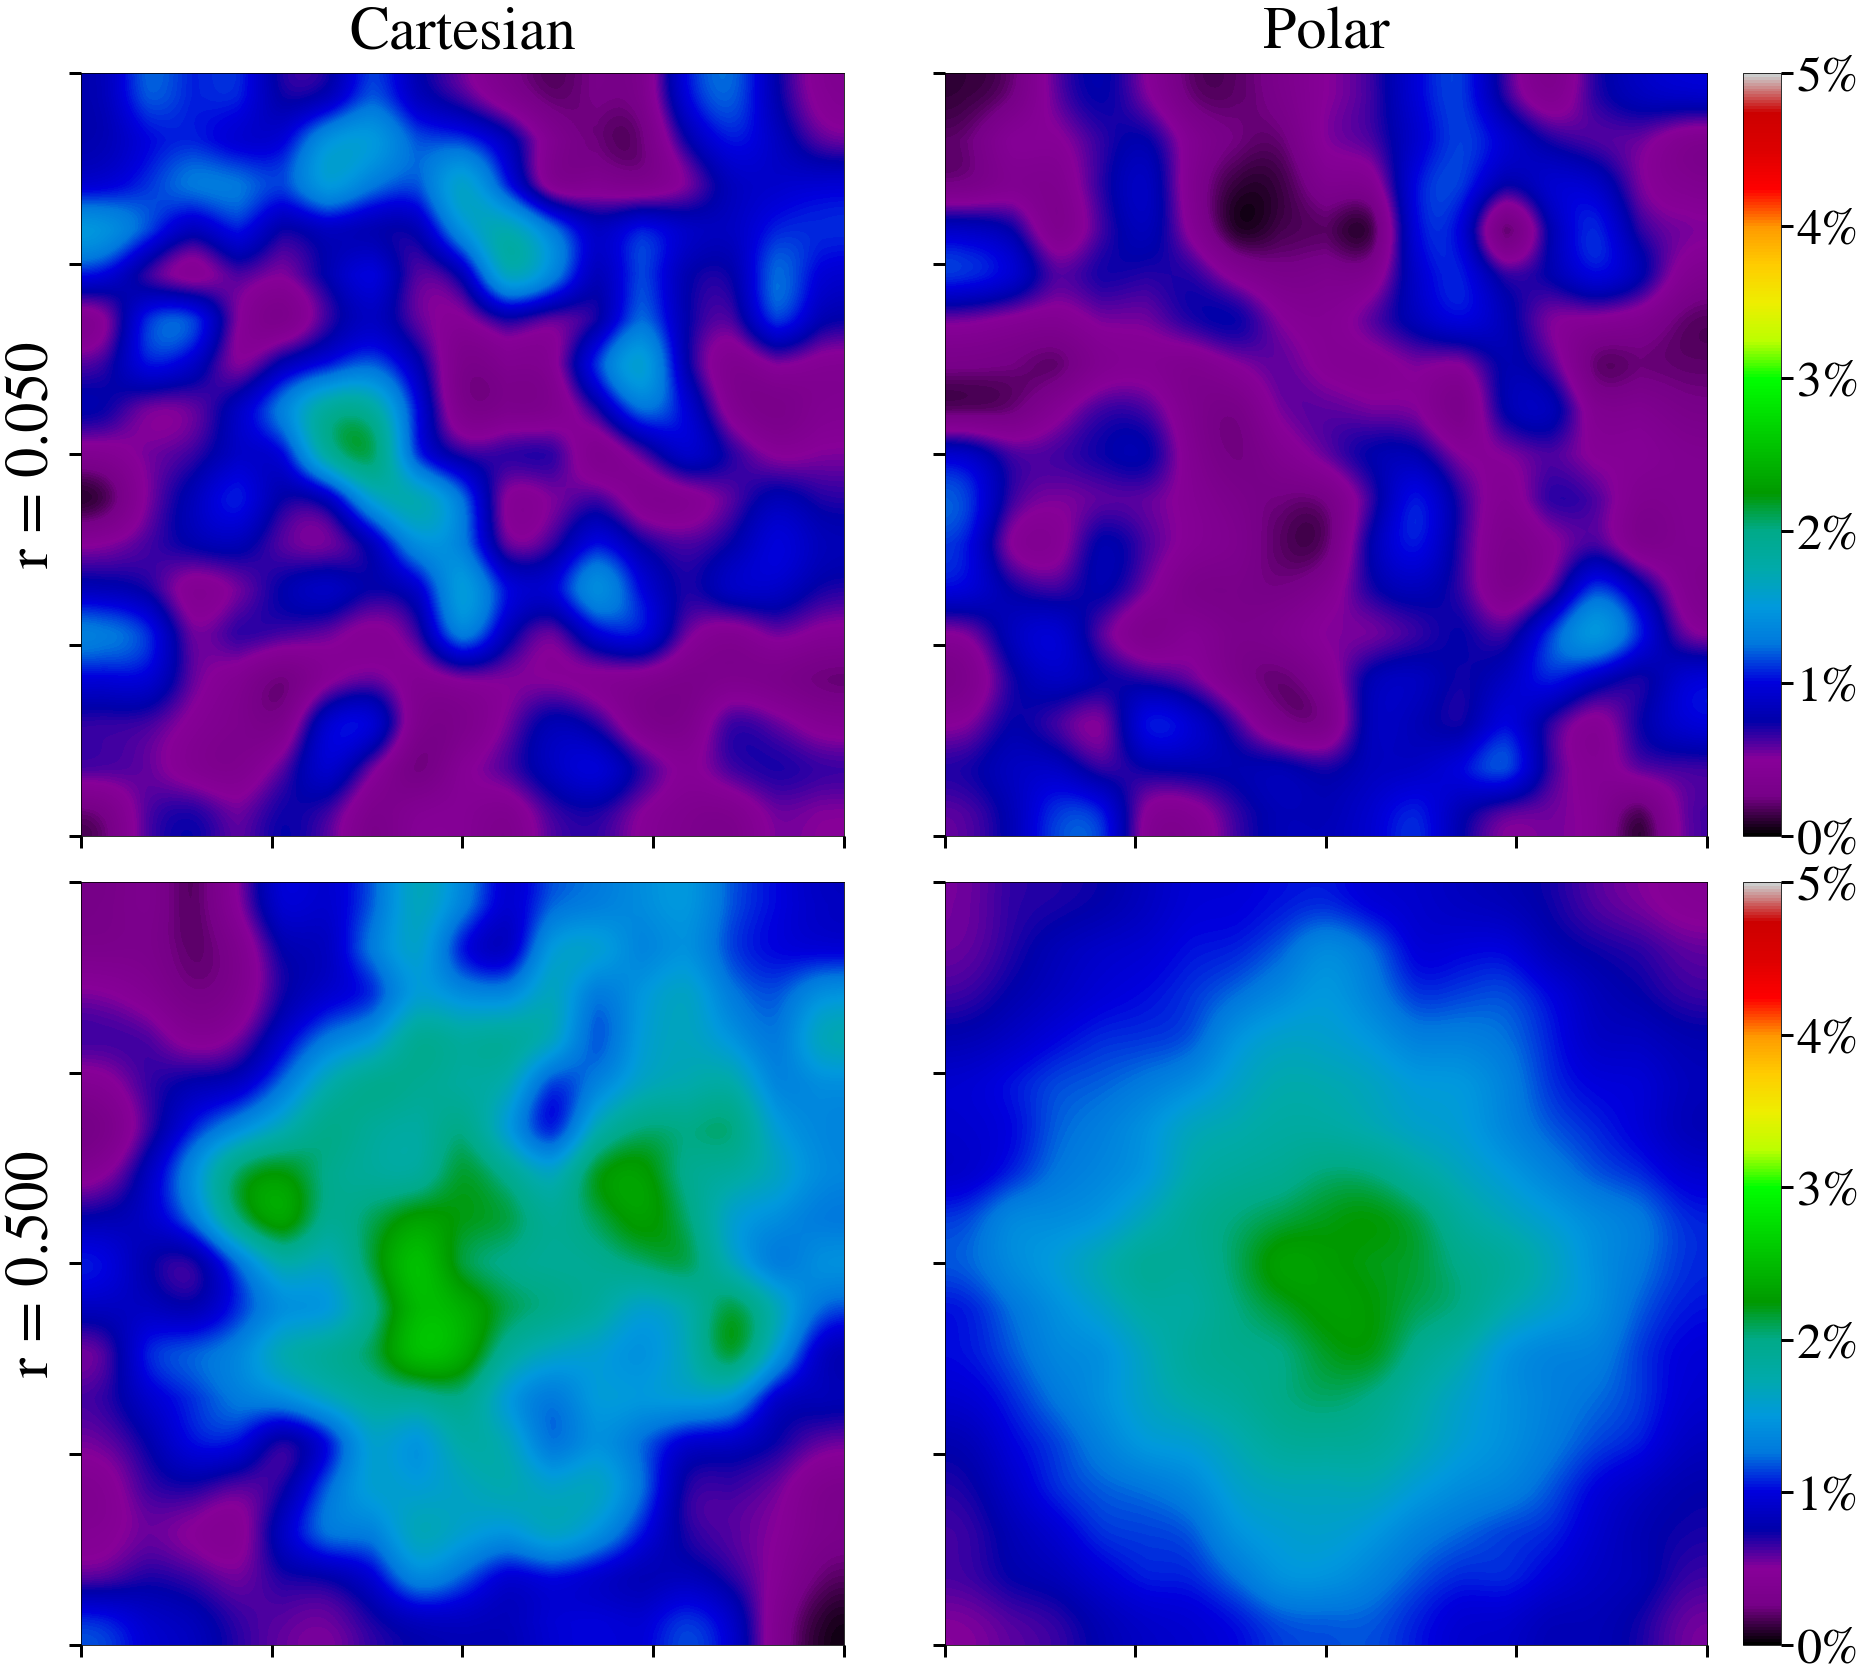

In [5]:
# Density Distribution Plots
rs = [0.2*r_av,2*r_av]
# rs = [r_av]
# rs = [1]
name = [['']*2]*(np.size(rs))
mean_bin = np.zeros((np.size(rs),2,17,17))
mean_bin_P = np.zeros((np.size(rs),2,17,17))
bins = np.zeros((np.size(rs),2,2,17,17))
r_minP = np.zeros(np.size(rs))
r_maxP = np.zeros(np.size(rs))
r_minT = np.zeros(np.size(rs))
r_maxT = np.zeros(np.size(rs))
domain = np.zeros((np.size(rs),3))

for i in range(np.size(rs)):
    maxT = 0
    maxP = 0
    minT = 500
    minP = 500
    j = 0
    r = rs[i]
    
    r_name = str(r).replace('.','')    
    _,_,_,_,_,_,_,_,_,bin_GT,bin_GT_P,_,_,_,_,_,_,_,num_bins,bin_width,bin_freq,train_zero_count,pred_zero_count,_,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
    bins[i,j,:,:,:] = np.meshgrid(np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1),np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1))
    mean_bin[i,j,:,:] = bin_GT/((T_end-T_beg)*F)
    mean_bin_P[i,j,:,:] = bin_GT_P/(T_pred*F)
    name[i][j] = f'GT, r = {np.round(copy.deepcopy(rs[i]),decimals=3)}'
    domain[i] = [-(num_bins*bin_freq + bin_width/2),0,(num_bins*bin_freq + bin_width/2)]
    
    if maxT < np.max(mean_bin[i][j]):
        maxT = np.max(mean_bin[i][j])
    if maxP < np.max(mean_bin_P[i][j]):
        maxP = np.max(mean_bin_P[i][j])
    if minT > np.min(mean_bin[i][j]):
        minT = np.min(mean_bin[i][j])
    if minP > np.min(mean_bin_P[i][j]):
        minP = np.min(mean_bin_P[i][j])
    
    for j in range(1,2):
        _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,bin_DMD,bin_DMD_P,num_bins,bin_width,bin_freq,_,_,train_zero_count_DMD,pred_zero_count_DMD = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
        mean_bin[i,j,:,:] = bin_DMD/((T_end-T_beg)*F)
        mean_bin_P[i,j,:,:] = bin_DMD_P/(T_pred*F)
        bins[i,j,:,:,:] = np.meshgrid(np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1),np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1))
        
        name[i][j] = 'DMD, r = {}'.format(np.round(copy.deepcopy(rs[i]),decimals=3))
        
        if maxT < np.max(mean_bin[i][j]):
            maxT = np.max(mean_bin[i][j])
        if maxP < np.max(mean_bin_P[i][j]):
            maxP = np.max(mean_bin_P[i][j])
        if minT > np.min(mean_bin[i][j]):
            minT = np.min(mean_bin[i][j])
        if minP > np.min(mean_bin_P[i][j]):
            minP = np.min(mean_bin_P[i][j])
    r_minP[i] = minP
    r_maxP[i] = maxP
    r_minT[i] = minT
    r_maxT[i] = maxT

# during training
fig = plt.figure(figsize=(25,23),constrained_layout=True)
grid = plt.GridSpec(np.size(rs), 2, figure=fig, hspace=0, wspace=-0.1)

axes = {}
caxes = {}
levels = []
for n in range(np.size(rs)):
    levels.append(np.linspace(0, r_maxT[n], 15))
#     caxes[str(n)] = fig.add_subplot(grid[n,3],visible=False)
    for m in range(2):
        axes[str(n)+str(m)] = fig.add_subplot(grid[n,m])


for n in range(np.size(rs)):
    for m in range(2):
#         cax = axes[str(n)+str(m)].contourf(bins[n,m,0],bins[n,m,1],mean_bin[n,m],cmap='gist_ncar',levels=levels[n])
#         im = axes[str(n)+str(m)].imshow(mean_bin[n,m],extent=[-1,1,-1,1],cmap='nipy_spectral',interpolation= 'spline16',vmin = np.amin(levels[n]),vmax = np.amax(levels[n]))
        im = axes[str(n)+str(m)].imshow(mean_bin[n,m],extent=[-1,1,-1,1],cmap='nipy_spectral',interpolation= 'spline16',vmin = 0,vmax = 5)
#         axes[str(n)+str(m)].set_xlabel(str(DTs[m]+', r = {:.3f}'.format(Rs[n])),fontsize=60)
        axes[str(n)+str(m)].tick_params(axis='x', labelsize=50)
        axes[str(n)+str(m)].tick_params(axis='y', labelsize=50)
        if n == 0:
            if m == 0:
                axes[str(n)+str(m)].set_title('Ground Truth',fontsize=60,y=1.0,pad=25)
            else:
                axes[str(n)+str(m)].set_title('Reconstruction',fontsize=60,y=1.0,pad=25)
        axes[str(n)+str(m)].set_xticklabels([])
        axes[str(n)+str(m)].set_yticklabels([])
        if m == 0:
            axes[str(n)+str(m)].set_ylabel('r = {:.3f}'.format(rs[n]),fontsize=60)
        else:
            axes[str(n)+str(m)].set_yticklabels([])
            
        axes[str(n)+str(m)].tick_params(axis='both',length=12,width=3)
    
    divider = make_axes_locatable(axes[str(n)+str(m)])
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cbar = fig.colorbar(im, cax = cax)#axP,ax = axesP[str(n)+str(m)])#,ticks=[0,r_maxP[n]])
    cbar.ax.tick_params(labelsize=50)
#     cbar = fig.colorbar(cax,ax = axes[str(n)+str(m)],ticks=[0,r_maxT[n]])
    cbar.ax.tick_params(labelsize=50, length=12,width=3)
    cbar.ax.set_yticklabels(['0%', '1%', '2%','3%','4%','5%'])
# fig.savefig('Figures/ForPaper/NEW-DensityTraining'+millname+'_eta'+eta_name+'_method'+method+randname, dpi=150,bbox_inches="tight")
    
# during prediction
figP = plt.figure(figsize=(25,23),constrained_layout=True)
gridP = plt.GridSpec(np.size(rs), 2, figure=figP, hspace=0, wspace=-0.1)

axesP = {}
levelsP = []
for n in range(np.size(rs)):
    levelsP.append(np.linspace(0, r_maxP[n], 15))
    for m in range(2):
        axesP[str(n)+str(m)] = figP.add_subplot(gridP[n,m])

for n in range(np.size(rs)):
    for m in range(2):
#         caxP = axesP[str(n)+str(m)].contourf(bins[n,m,0],bins[n,m,1],mean_bin_P[n,m],cmap='gist_ncar',levels=levelsP[n])
#         imP = axesP[str(n)+str(m)].imshow(mean_bin_P[n,m],extent=[-1,1,-1,1],cmap='nipy_spectral',interpolation= 'spline16',vmin = np.amin(levelsP[n]),vmax = np.amax(levelsP[n]))
        imP = axesP[str(n)+str(m)].imshow(mean_bin_P[n,m],extent=[-1,1,-1,1],cmap='nipy_spectral',interpolation= 'spline16',vmin = 0,vmax = 5)
        axesP[str(n)+str(m)].tick_params(axis='x', labelsize=50)
        axesP[str(n)+str(m)].tick_params(axis='y', labelsize=50)
        if n == 0:
            if m == 0:
#                 axesP[str(n)+str(m)].set_title('Ground Truth',fontsize=60,y=1.0,pad=25)
                axesP[str(n)+str(m)].set_title('Cartesian',fontsize=60,y=1.0,pad=25)
            else:
#                 axesP[str(n)+str(m)].set_title('Prediction',fontsize=60,y=1.0,pad=25)
                axesP[str(n)+str(m)].set_title('Polar',fontsize=60,y=1.0,pad=25)
        axesP[str(n)+str(m)].set_xticklabels([])
        axesP[str(n)+str(m)].set_yticklabels([])
        if m == 0:
            axesP[str(n)+str(m)].set_ylabel('r = {:.3f}'.format(rs[n]),fontsize=60)
        else:
            axesP[str(n)+str(m)].set_yticklabels([])
        
        axesP[str(n)+str(m)].tick_params(axis='both',length=12,width=3)
                  
    dividerP = make_axes_locatable(axesP[str(n)+str(m)])
    caxP = dividerP.append_axes("right", size="5%", pad=0.5)
    cbarP = figP.colorbar(imP, cax = caxP)#axP,ax = axesP[str(n)+str(m)])#,ticks=[0,r_maxP[n]])
    cbarP.ax.tick_params(labelsize=50, length=12,width=3)
    cbarP.ax.set_yticklabels(['0%', '1%', '2%','3%','4%','5%'])
#     figP.colorbar(cax,ax = [axesP],ticks=[r_minP[n],r_maxP[n]])
# figP.savefig('Figures/ForPaper/NEW-DensityPrediction'+millname+'_eta'+eta_name+'_method'+method+randname, dpi=150,bbox_inches="tight")
figP.savefig('Figures/ForPaper/tester', dpi=150,bbox_inches="tight")

In [17]:
train_zero_count

array(0, dtype=int64)

mDMDc_datatype13_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit5_WF100


C:\Users\evich\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


False
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit5_WF100
False
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit5_WF100
False


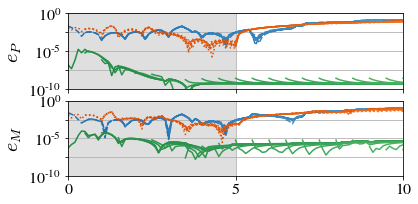

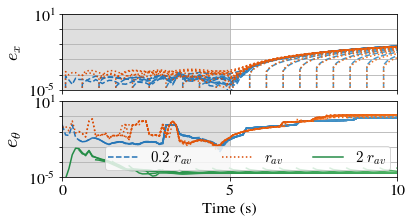

In [13]:
# Waterfall plots
# rs = [0.2*r_av,r_av,2*r_av] #20%, 100%, and 200% of r_av
iterate_labels = [r'$0.2 \ r_{av}$',r'$r_{av}$', r'$2 \ r_{av}$']
T_start = 0
T_stop = 100
vert_bars = np.linspace(T_start,T_stop,3,dtype=int)[:-1]
# colours = [[ cm.viridis(x) for x in np.linspace(0.0, 1.0, super_steps) ],[ cm.ocean(x) for x in np.linspace(0.0, 1.0, super_steps) ],[ cm.inferno(x) for x in np.linspace(0.0, 1.0, super_steps) ]]
colours = [[ cm.Blues_r(x) for x in np.linspace(0.25, 0.75, super_steps) ],[ cm.Oranges_r(x) for x in np.linspace(0.25, 0.75, super_steps) ],[ cm.Greens_r(x) for x in np.linspace(0.25, 0.75, super_steps) ]]
# rs = [1] # milling
linetypes = ['dashed','dotted','solid','dotted',(0,(3,1,1,1,1,1)),(0,(1,1))]
ticklabels = np.arange(0,dt*T_stop+1,5)

x_err = np.zeros((super_steps,waterfall,3))
y_err = np.zeros((super_steps,waterfall,3))
pos_err = np.zeros((super_steps,waterfall,3))
h_err = np.zeros((super_steps,waterfall-1,3))
D_err = np.zeros((super_steps,waterfall,3))
P_err = np.zeros((super_steps,waterfall-1,3))
Mang_err = np.zeros((super_steps,waterfall-1,3))
Mabs_err = np.zeros((super_steps,waterfall-1,3))

i = 0
for r in rs:
    r_name = str(r).replace('.','')

    X_GT3d,dt,v_truth,DMD_range,X_GT,D_GT,P_GT,Mang_GT,Mabs_GT,X_DMD,D_DMD,P_DMD,Mang_DMD,Mabs_DMD = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)

    for k in range(super_steps):
        DMD_range = np.minimum(waterfall,TN-k*re_init)
        x_err[k,:DMD_range,i] = np.mean(np.abs(position_difference(L,X_DMD[:N,:DMD_range,k], X_GT[:N,k*re_init:k*re_init+waterfall])),axis=0)
        y_err[k,:DMD_range,i] = np.mean(np.abs(position_difference(L,X_DMD[N:,:DMD_range,k], X_GT[N:,k*re_init:k*re_init+waterfall])),axis=0)

        X_DMD_dot = position_difference(L,X_DMD[:,:DMD_range-1,k],X_DMD[:,1:DMD_range,k])/dt
        X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])
        X_GT_dot = position_difference(L,X_GT[:,k*re_init:k*re_init+DMD_range-1],X_GT[:,k*re_init+1:k*re_init+DMD_range])/dt
        X_GT_heading = np.arctan2(X_GT_dot[N:,:],X_GT_dot[:N,:])
        h_err[k,:DMD_range-1,i] = np.mean(np.absolute(X_DMD_heading-X_GT_heading), axis=0)
        X_diff = position_difference(L,X_DMD[:,:DMD_range,k], X_GT[:,k*re_init:k*re_init+DMD_range])
        pos_err[k,:DMD_range,i] = np.mean(np.linalg.norm(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2),axis=2),axis=0)

        D_err[k,:DMD_range,i] = np.abs(D_DMD[k,:DMD_range]-D_GT[k*re_init:k*re_init+waterfall].flatten())
        P_err[k,:DMD_range-1,i] = np.abs(P_DMD[k,:DMD_range-1]-P_GT[k*re_init:k*re_init+(waterfall-1)].flatten())
        Mang_err[k,:DMD_range-1,i] = np.abs(Mang_DMD[k,:DMD_range-1]-Mang_GT[k*re_init:k*re_init+(waterfall-1)].flatten())
        Mabs_err[k,:DMD_range-1,i] = np.abs(Mabs_DMD[k,:DMD_range-1]-Mabs_GT[k*re_init:k*re_init+(waterfall-1)].flatten())

    print(P_err[0,:,0]==h_err[0,:,0])
    i=i+1

    
fig1 = plt.figure(figsize=(3*len(vert_bars),3))
grid = plt.GridSpec(2, 1, figure=fig1, hspace=0.15, wspace=0.3)

ax1 = fig1.add_subplot(grid[0,0])
ax2 = fig1.add_subplot(grid[1,0])

for i in range(3):
    for k in range(super_steps):
        DMD_range = np.minimum(waterfall,TN-k*re_init)
        if k == 0:
            ax1.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),P_err[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i],label=iterate_labels[i])
            ax2.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),Mang_err[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i],label=iterate_labels[i])
        else:
            ax1.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),P_err[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i])
            ax2.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),Mang_err[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i])
            
ax1.set_ylabel(r"$e_P$",fontsize=20)
ax1.set_ylim(bottom=1E-10,top=1E0)
ax1.set_xlim(left=0,right=dt*TN)
ax1.grid()
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_xticks(ticklabels)
ax1.set_xticklabels([])
ax1.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
ax1.set_yticks(np.logspace(-10,0,5))
ax1.set_xlim(left=dt*T_start,right=dt*T_stop)

ax2.set_ylabel(r"$e_M$",fontsize=20)
ax2.set_ylim(bottom=1E-10,top=1E0)
ax2.set_xlim(left=0,right=dt*TN)
ax2.grid()
ax2.tick_params(axis='both', labelsize=16)
ax2.set_yticks(np.logspace(-10,0,5))
ax2.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
ax2.set_xlim(left=dt*T_start,right=dt*T_stop)
ax2.set_xticks(ticklabels)
# ax2.legend(loc='lower right',fontsize=15,ncol=len(iterates),borderpad=0.2, labelspacing=0.3)


fig2 = plt.figure(figsize=(3*len(vert_bars),3))
grid = plt.GridSpec(2, 1, figure=fig2, hspace=0.15, wspace=0.3)

# ax3 = fig2.add_subplot(grid[0,0])
ax4 = fig2.add_subplot(grid[0,0])
ax5 = fig2.add_subplot(grid[1,0])

for i in range(3):
    for k in range(super_steps):
        DMD_range = np.minimum(waterfall,TN-k*re_init)
#         ax3.semilogy(dt*range(k*re_init,k*re_init+DMD_range),x_err[k,:DMD_range,i],color=colours[i][k],linestyle=linetypes[i])
#         ax4.semilogy(dt*range(k*re_init,k*re_init+DMD_range),y_err[k,:DMD_range,i],color=colours[i][k],linestyle=linetypes[i])
        if k==0:
            ax4.semilogy(dt*range(k*re_init,k*re_init+DMD_range),pos_err[k,:DMD_range,i],color=colours[i][k],linestyle=linetypes[i],label=iterate_labels[i])
            ax5.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),h_err[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i],label=iterate_labels[i])
        else:
            ax4.semilogy(dt*range(k*re_init,k*re_init+DMD_range),pos_err[k,:DMD_range,i],color=colours[i][k],linestyle=linetypes[i])
            ax5.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),h_err[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i])
            
# ax3.set_ylabel(r"$e_x$",fontsize=20)
# ax3.grid()
# ax3.set_ylim(bottom=1E-7,top=1E1)
# ax3.tick_params(axis='x', labelsize=12)
# ax3.tick_params(axis='y', labelsize=12)
# ax3.set_xticklabels([])

ax4.set_ylabel(r"$e_x$",fontsize=18)
ax4.grid()
ax4.set_ylim(bottom=1E-5,top=1E1)
ax4.set_xticklabels([])
ax4.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
ax4.set_xlim(left=dt*T_start,right=dt*T_stop)
ax4.set_xticks(ticklabels)
ax4.tick_params(axis='both', labelsize=16)
ax4.set_yticks(np.logspace(-5,1,6))

ax5.set_ylabel(r"$e_\theta$",fontsize=20)
ax5.grid(True)
ax5.set_ylim(bottom=1E-5,top=1E1)
ax5.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
ax5.set_xlim(left=dt*T_start,right=dt*T_stop)
ax5.tick_params(axis='both', labelsize=16)
ax5.set_yticks(np.logspace(-5,1,6))
ax5.set_xticks(ticklabels)
ax5.set_xlabel('Time (s)',fontsize=16)
ax5.legend(loc='lower right',fontsize=15,ncol=len(rs),borderpad=0.2, labelspacing=0.3)

# fig1.savefig('Figures/ForPaper/PMerrorcomp_waterfall'+'_eta'+eta_name+'_r'+r_name+'_method'+method, dpi=150,bbox_inches='tight')
# fig2.savefig('Figures/ForPaper/Poserrorcomp_waterfall'+'_eta'+eta_name+'_r'+r_name+'_method'+method, dpi=150,bbox_inches='tight')
fig1.savefig('Figures/ForPaper/PMerrorcomp_waterfall'+'_eta'+eta_name+'_method'+method+'_reinit'+str(re_init), dpi=150,bbox_inches='tight')
fig2.savefig('Figures/ForPaper/Poserrorcomp_waterfall'+'_eta'+eta_name+'_method'+method+'_reinit'+str(re_init), dpi=150,bbox_inches='tight')

In [59]:
# Data tables
N = 50
rho = 16
milling = 0
datatypes = [13,20,21]
methods = ['simple','FO_cartesian','FO_polar']
etas = [0,np.pi/12]
rs = [0.2*r_av,r_av,2*r_av,1]

# N = 200
# rho = 2.5
# milling = 1
# datatypes = [13]
# methods = ['simple']
# etas = [0.08726646259971647]
# rs = [1]

error_table = np.zeros((len(methods)*(len(rs)-1)*len(etas)+1,11))
GT_table = np.zeros((len(methods)*(len(rs)-1)*len(etas)+1,7))

j=0
i = 0
for method in methods:
    datatype = datatypes[i]
    for r in rs:
        if r == 1 and datatype==13:
            etas = [0.08726646259971647]
            N = 200
            rho = 2.5
            milling = 1
            rs = [0.2*r_av,r_av,2*r_av]
            L = np.sqrt(1000/rho)
        else:
            etas = [0,np.pi/12]
            N = 50
            rho = 16
            milling = 0
            L = np.sqrt(N/rho)
        for eta in etas:
            r_name = str(r).replace('.','')
            eta_name = str(eta).replace('.','')
            _,dt,_,TN,X_GT0,_,P_GT0,Mang_GT0,_,_,_,X_DMD0,_,P_DMD0,Mang_DMD0,_,_,_,_,_,_,_,_,_,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
            _,_,pos_errs0 = ProcessData_StandardErrors(X_GT0,X_DMD0,L)
            time = np.arange(0,TN*30,dt)

            X_DMD_dot0 = position_difference(L,X_DMD0[:,:-1],X_DMD0[:,1:])/dt
            X_DMD_heading0 = np.arctan2(X_DMD_dot0[N:,:],X_DMD_dot0[:N,:])
            X_GT_dot0 = position_difference(L,X_GT0[:,:-1],X_GT0[:,1:])/dt
            X_GT_heading0 = np.arctan2(X_GT_dot0[N:,:],X_GT_dot0[:N,:])
            h_diff = np.absolute(X_DMD_heading0-X_GT_heading0)
            h_errs0 = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)
#             h_errs0 = np.mean(np.absolute(X_DMD_heading0-X_GT_heading0), axis=0)

            Mang_errs0 = np.absolute(Mang_GT0-Mang_DMD0)
            P_errs0 = np.absolute(P_GT0-P_DMD0)
    
            t_P = np.inf if np.max(P_errs0[T_end:]>1e-01)==False else time[np.argmax(P_errs0[T_end:]>1e-01)]
            t_Mang = np.inf if np.max(Mang_errs0[T_end:]>1e-01)==False else time[np.argmax(Mang_errs0[T_end:]>1e-01)]
            t_pos = np.inf if np.max((pos_errs0[T_end:]/L)>1e-01)==False else time[np.argmax((pos_errs0[T_end:]/L)>1e-01)]
            t_h = np.inf if np.max(h_errs0[T_end:]>1e-01)==False else time[np.argmax(h_errs0[T_end:]>1e-01)]

            error_table[j,:] = [datatype,r,eta,t_pos,t_h,t_P,t_Mang,np.mean(pos_errs0[:50]/L),np.mean(h_errs0[:50]),np.mean(P_errs0[:50]),np.mean(Mang_errs0[:50])]
            GT_table[j,:] = [datatype,r,eta,np.mean(P_GT0[:50]),np.mean(Mang_GT0[:50]),np.mean(P_GT0[50:100]),np.mean(Mang_GT0[50:100])]
            
            j=j+1
    i=i+1
            
np.savetxt("errors.csv", error_table, delimiter=",")
np.savetxt("GT.csv", GT_table, delimiter=",")

mDMDc_datatype13_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A200_eta008726646259971647_W0_rho2.5_r1_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0_milling
300
(200, 299, 2)
mDMDc_datatype20_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rh

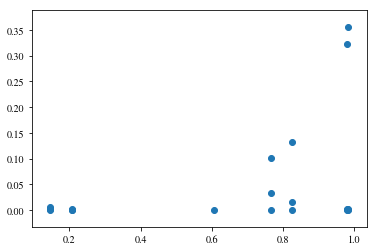

In [87]:
# GT_table
plt.scatter(GT_table[:,3],error_table[:,9])

In [90]:
error_table[:,9]

array([5.22226246e-05, 2.28778349e-04, 1.24900425e-04, 2.63913809e-04,
       1.34369521e-06, 2.45227695e-04, 7.33037962e-04, 4.44244984e-04,
       1.35006344e-03, 1.31550364e-01, 1.01231467e-01, 3.55897670e-01,
       3.22045182e-01, 1.61637233e-03, 5.55317998e-03, 1.53915013e-02,
       3.32595853e-02, 2.08135370e-03, 3.07199088e-03])

In [6]:
def fill_axes_traj(axis,X_GT,X_DMD,N,L,vert_bars,dt,rs_used):
#     num_plots = np.shape(X_GT)[1]
    r_legend = {'0.05':0,'0.25': 1, '0.5': 2,'1':0}
    tail_length = vert_bars[1]-vert_bars[0]
    print(tail_length)
    num_plots = len(vert_bars)
    num_datasets = np.shape(X_DMD)[2]
    print(num_datasets)
    fig = plt.figure(figsize=(3*len(vert_bars),2.8))
    grid = plt.GridSpec(1, num_plots, figure=fig, hspace=0.15, wspace=0.15)
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    coloursGT = ['lightskyblue','bisque','lightgreen']
    
    ax = {}
    for i in range(num_plots):
        ax[str(i)] = fig.add_subplot(grid[0,i])
#     ax2 = fig.add_subplot(grid[0,1])
#     ax3 = fig.add_subplot(grid[0,2])
    
    for i in range(num_plots):
        plt.set_cmap('Pastel1')
        for j in range(num_datasets):
            ax[str(i)].scatter(X_GT[:N,vert_bars[i],j],X_GT[N:,vert_bars[i],j],c=coloursGT[r_legend[str(rs_used[j])]],s=30,zorder=4+j,alpha=1,linewidths=0.75,edgecolor='dimgrey',marker="P")
            ax[str(i)].plot(X_DMD[:N,vert_bars[i]:vert_bars[i]+tail_length,j].T,X_DMD[N:,vert_bars[i]:vert_bars[i]+tail_length,j].T,zorder=-1,c=colours[r_legend[str(rs_used[j])]],linestyle='',marker='o',markersize=2)
            ax[str(i)].plot(X_GT[:N,vert_bars[i]:vert_bars[i]+tail_length,j].T,X_GT[N:,vert_bars[i]:vert_bars[i]+tail_length,j].T,zorder=-2,c='dimgrey',linestyle='',marker='o',markersize=2,alpha=0.6)
            ax[str(i)].scatter(X_DMD[:N,vert_bars[i],j],X_DMD[N:,vert_bars[i],j],c=colours[r_legend[str(rs_used[j])]],s=40,zorder=j,edgecolor='k')
        
        if not milling:
            ax[str(i)].set_xlim(left=0,right=L)
            ax[str(i)].set_ylim(bottom=0,top=L)
            ax[str(i)].text(0+0.02, -0.2, r"$t\in[{start},{stop})$".format(start=np.round(dt*vert_bars[i],decimals=3),stop=np.round(dt*vert_bars[i]+5,decimals=3)), style='italic',fontsize=18 ,
            bbox={'facecolor': 'dimgrey', 'alpha': 0, 'pad': 5})
        else:
            ax[str(i)].set_xlim(left=(L/2)-5,right=(L/2)+5)
            ax[str(i)].set_ylim(bottom=(L/2)-5,top=(L/2)+5)
            ax[str(i)].text((L/2)-5+0.02, (L/2)-5-1.2, r"$t\in[{start},{stop})$".format(start=np.round(dt*vert_bars[i],decimals=3),stop=np.round(dt*vert_bars[i]+5,decimals=3)), style='italic',fontsize=18 ,
            bbox={'facecolor': 'dimgrey', 'alpha': 0, 'pad': 5})
        if True: #i>0:
#             ax[str(i)].set_yticklabels([])
            ax[str(i)].xaxis.set_visible(False)
            ax[str(i)].yaxis.set_visible(False)
            
        ax[str(i)].tick_params(axis='both', labelsize=16)
        row
    
    return fig 

re init: 0
not in reinit
simple
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 99, 2)
not in reinit
simple
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 99, 2)
not in reinit
simple
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 99, 2)
plotting
re init: 1
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit5_WF100
in reinit
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit5_WF100
in reinit
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit5_WF100
in reinit
plotting


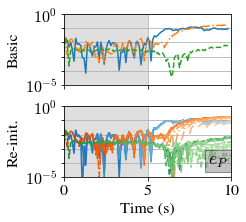

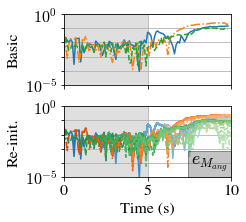

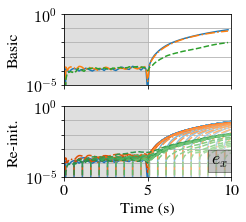

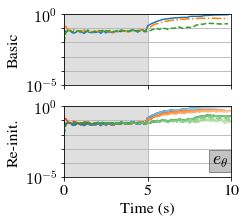

In [9]:
# Collective(?) Plots

def build_figure(rows,cols):
    fig = plt.figure(figsize=(3,(3/2)*rows))
    grid = plt.GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.3)

    axes = {}
    for i in range(rows*cols):
        axes[str(i)] = fig.add_subplot(grid[i,0])
    
    return fig, axes

def fill_axes(fig, axis, name, data, time, iterates, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall, milling,end_flag, title):
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    linetypes = ['solid','dashdot','dashed','dotted',(0,(3,1,1,1,1,1)),(0,(1,1))]
    time = np.arange(0,dt*T_stop,dt)
    ticklabels = np.arange(0,dt*T_stop+1,5)
    
    plt.set_cmap('Pastel1')
    axis.set_ylabel(name,fontsize=16)
    if reinit:
        colours = [np.concatenate(([ cm.Blues_r(x) for x in np.linspace(0.25, 0.75, 21) ],[ cm.Blues_r(x) for x in np.linspace(0.25, 0.75, super_steps-21) ]),axis=0),
                   np.concatenate(([ cm.Oranges_r(x) for x in np.linspace(0.25, 0.75, 21) ],[ cm.Oranges_r(x) for x in np.linspace(0.25, 0.75, super_steps-21) ]),axis=0),
                   np.concatenate(([ cm.Greens_r(x) for x in np.linspace(0.25, 0.75, 21) ],[ cm.Greens_r(x) for x in np.linspace(0.25, 0.75, super_steps-21) ]),axis=0)]
        for i in range(len(iterates)):
            for k in range(super_steps):
                DMD_range = np.minimum(waterfall,TN-k*re_init)
                if k == 0:
                    axis.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),data[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i],label=iterate_labels[i])
                else:
                    axis.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),data[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i])
    else:
        for j in range(len(iterates)):
            if milling:
                axis.semilogy(time[:-1],data[:,j],color = colours[4],label=iterate_labels[j],linestyle=linetypes[j])
            else:
                axis.semilogy(time[:-1],data[:,j],color = colours[j],label=iterate_labels[j],linestyle=linetypes[j])
    
    axis.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
    axis.grid()
    axis.set_ylim(bottom=1E-5,top=1E0)
    axis.set_xlim(left=0,right=dt*T_stop)
    axis.tick_params(axis='both', labelsize=16)
    axis.set_xticks(ticklabels)
    axis.set_yticks(np.logspace(-5,0,6))
    axis.set_yticklabels([r"$10^{-5}$",'','','','',r"$10^{0}$"])
    if end_flag:
        axis.set_xlabel('Time (s)',fontsize=16)
        axis.text(9.8, 8e-05, title,fontsize=18, bbox={'facecolor': 'dimgrey', 'alpha': 0.4, 'pad': 3},ha='right')
    else:
        axis.set_xticklabels([])
    
    return fig
    
# settings = [[0,0],[0,1],[1,0]] # [milling, reinit] - eta 0 with milling
# settings = [[0,0],[0,0]] # [milling, reinit] - FO
settings = [[0,0],[0,1]] # [milling, reinit] - eta pi/12 no milling
T_start = 0
T_stop = 100
Pfig, Paxes = build_figure(len(settings),1)
Mfig, Maxes = build_figure(len(settings),1)
posfig, posaxes = build_figure(len(settings),1)
hfig, haxes = build_figure(len(settings),1)


if milling:
    L = np.sqrt(1000/rho)
else:
    L = np.sqrt(N/rho)

j = 0
for setting in settings:
    milling = setting[0]
    reinit = setting[1]
    
    if milling:
        N = 200
        rho = 2.5
        datatype = 13
        method = 'simple'
        eta = 0.08726646259971647
        rs = [1]
        L = np.sqrt(1000/rho)
        iterate_labels = [r'$1$']
        name = "Milling"
    else:
        N = 50
        rho = 16
        datatype = 13
#         datatypes = [20,21]
        method = 'simple'
#         methods = ['FO_cartesian','FO_polar']
#         eta = 0
        eta = np.pi/12
        rs = [0.2*r_av,r_av,2*r_av]
        L = np.sqrt(N/rho)
        iterate_labels = [r'$0.05$',r'$0.25$', r'$0.5$']
        name = "Basic"
#         names = ["Cartesian", "Polar"]
    
    if reinit:
        re_init = 5
        waterfall = 100
        super_steps = (TN-T_init)//re_init
        DMD_range = re_init*super_steps-1
        
        pos_err = np.zeros((super_steps,waterfall,np.size(rs)))
        h_err = np.zeros((super_steps,waterfall-1,np.size(rs)))
        P_err = np.zeros((super_steps,waterfall-1,np.size(rs)))
        Mang_err = np.zeros((super_steps,waterfall-1,np.size(rs)))
        
        name = "Re-init."
        
    else:
        re_init = 0
        waterfall = 0
        
        rs_used = [r_av]
        
        P_err = np.zeros((T_stop-T_start-1,np.size(rs)))
        Mang_err = np.zeros((T_stop-T_start-1,np.size(rs)))
        pos_err = np.zeros((T_stop-T_start-1,np.size(rs)))
        h_err = np.zeros((T_stop-T_start-1,np.size(rs)))
        X_GT_tail = np.zeros((2*N,(T_stop-T_start)+1,len(rs_used)))
        X_DMD_tail = np.zeros((2*N,(T_stop-T_start)+1,len(rs_used)))
    
#     method = methods[j] #Comment out for simple
#     datatype = datatypes[j] #Comment out for simple
#     name = names[j] #Comment out for simple
    
    print('re init:', str(reinit))
    i = 0
    for r in rs:
        r_name = str(r).replace('.','')
        eta_name = str(eta).replace('.','')
        
        if reinit:
            TN = 300
            _,dt,_,DMD_range,X_GT,_,P_GT,Mang_GT,_,X_DMD,_,P_DMD,Mang_DMD,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
            print('in reinit')
            for k in range(super_steps):
                DMD_range = np.minimum(waterfall,TN-k*re_init)

                X_DMD_dot = position_difference(L,X_DMD[:,:DMD_range-1,k],X_DMD[:,1:DMD_range,k])/dt
                X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])
                X_GT_dot = position_difference(L,X_GT[:,k*re_init:k*re_init+DMD_range-1],X_GT[:,k*re_init+1:k*re_init+DMD_range])/dt
                X_GT_heading = np.arctan2(X_GT_dot[N:,:],X_GT_dot[:N,:])
                h_diff = np.absolute(X_DMD_heading-X_GT_heading)
                h_err[k,:DMD_range-1,i] = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)
#                 h_err[k,:DMD_range-1,i] = np.mean(np.absolute(X_DMD_heading-X_GT_heading), axis=0)
                X_diff = position_difference(L,X_DMD[:,:DMD_range,k], X_GT[:,k*re_init:k*re_init+DMD_range])
                pos_err[k,:DMD_range,i] = np.mean(np.linalg.norm(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2),axis=2),axis=0)/L

                P_err[k,:DMD_range-1,i] = np.abs(P_DMD[k,:DMD_range-1]-P_GT[k*re_init:k*re_init+(waterfall-1)].flatten())
                Mang_err[k,:DMD_range-1,i] = np.abs(Mang_DMD[k,:DMD_range-1]-Mang_GT[k*re_init:k*re_init+(waterfall-1)].flatten())
            
            i=i+1
#             print(P_err[0,:,0]==h_err[0,:,0])

        else:
            print('not in reinit')
            print(method)
            _,dt,_,TN,X_GT,_,P_GT,Mang_GT,_,_,_,X_DMD,_,P_DMD,Mang_DMD,_,_,_,_,_,_,_,_,_,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
            _,_,pos_err_temp = ProcessData_StandardErrors(X_GT[:,T_start:T_stop],X_DMD[:,T_start:T_stop],L)
            pos_err[:,i] = pos_err_temp/L
#             if r == rs_used[0]:
#                 X_GT_tail[:,:,0] = X_GT[:,:(T_stop-T_start)+1]
#                 X_DMD_tail[:,:,0] = np.copy(X_DMD[:,:(T_stop-T_start)+1])
#                 agent_plots = fill_axes_traj(X_GT_tail,X_DMD_tail,N,L,[0,50],dt,rs_used)
            
            X_DMD_dot = position_difference(L,X_DMD[:,:-1],X_DMD[:,1:])/dt
            X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])
            X_GT_dot = position_difference(L,X_GT[:,:-1],X_GT[:,1:])/dt
            X_GT_heading = np.arctan2(X_GT_dot[N:,:],X_GT_dot[:N,:])
            h_diff = np.absolute(X_DMD_heading[:,T_start:T_stop-1]-X_GT_heading[:,T_start:T_stop-1])
            h_err[:,i] = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)
#             h_err[:,i] = np.mean(np.absolute(X_DMD_heading[:,T_start:T_stop-1]-X_GT_heading[:,T_start:T_stop-1]), axis=0)

            Mang_err[:,i] = np.absolute(Mang_GT[T_start:T_stop-1]-Mang_DMD[T_start:T_stop-1])
            P_err[:,i] = np.absolute(P_GT[T_start:T_stop-1]-P_DMD[T_start:T_stop-1])
            time = np.arange(dt*T_start,dt*T_stop,dt)
            i = i+1
            
    print('plotting')
    end_flag = (j==(len(settings)-1))
    Pfig = fill_axes(Pfig, Paxes[str(j)], name, P_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_P$")
    Mfig = fill_axes(Mfig, Maxes[str(j)], name, Mang_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_{M_{ang}}$")
    posfig = fill_axes(posfig, posaxes[str(j)], name, pos_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_x$")
    hfig = fill_axes(hfig, haxes[str(j)], name, h_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_\theta$")
#     if reinit:
#         print(P_err[0,:,0]==h_err[0,:,0])
    j = j+1

Pfig.savefig('Figures/ForPaper/Polarisation'+'_eta'+eta_name, dpi=150,bbox_inches='tight')
Mfig.savefig('Figures/ForPaper/AngularMomentum'+'_eta'+eta_name, dpi=150,bbox_inches='tight')
posfig.savefig('Figures/ForPaper/Position'+'_eta'+eta_name, dpi=150,bbox_inches='tight')
hfig.savefig('Figures/ForPaper/Heading'+'_eta'+eta_name, dpi=150,bbox_inches='tight')


In [ ]:
np.logspace(-5,0,6)[::5]

In [154]:
def interp_jump_correction(X,T_start,T_stop,L,dt,dt_new,X_new_stack):
    """corrects interpolation over periodic boundary by identifying individual agents who 
    cross the boundary, and breaking up their tracjectories into two parts split at that
    crossing."""
    X_stack = np.concatenate((X[:,T_start:T_stop+1,0],X[:,T_start:T_stop+1,1]),axis=0)
    X_diff = np.diff(X_stack[:,:])
    diff_locs = np.argwhere(np.abs(X_diff)>(L/2))
    diff_locs = diff_locs[np.argsort(diff_locs[:,1]),:]
    jump_agents = X_stack[diff_locs[:,0],:]

    for i in range(np.shape(diff_locs)[0]):
        temp1 = jump_agents[i,:diff_locs[i,1]+1]
        temp2 = jump_agents[i,diff_locs[i,1]+1:]

        if temp2[0]-temp1[-1]<0:
            temp1 = np.concatenate((temp1,[temp2[0]+L]))
        else:
            temp1 = np.concatenate((temp1,[temp2[0]-L]))

        t1 = np.arange(0,diff_locs[i,1]+2,dt)
        t2 = np.arange(diff_locs[i,1]+1,T_stop+1-600,dt)

        t1_new = np.arange(0,diff_locs[i,1]+1,dt_new)
        t2_new = np.arange(diff_locs[i,1]+1,T_stop-600,dt_new)
        f1 = interp1d(t1,temp1)
        temp1_new = f1(t1_new)

        if len(temp2) != 1:
            f2 = interp1d(t2,temp2)
            temp2_new = f2(t2_new)
        else:
            temp2_new = []


        agent_new = np.concatenate((temp1_new,temp2_new))
        agent = wrap_position(L,agent_new)

        X_new_stack[diff_locs[i,0],:] = agent

    X_new = np.stack((X_new_stack[:N,:],X_new_stack[N:,:]),axis=2)
    return X_new

def wrap_position(L,agent):
    boundaryT_index = np.where(agent>L)
    boundaryB_index = np.where(agent<0)

    agent[boundaryT_index] = agent[boundaryT_index] - L*(agent[boundaryT_index]//L)
    agent[boundaryB_index] = agent[boundaryB_index] - L*(agent[boundaryB_index]//L)
    
    return agent

In [157]:
# Pre-process milling data - Interpolate!
from scipy.interpolate import interp1d

N = 1000 # number of agents
rho = 2.5 # density

wide = 0 # to make domain wider than initial condition
if wide:
    L0 = np.sqrt(N/rho) # length of domain of agent initial positions
    L = 1.1*L0 # length of domain square side 
else:
    L0 = np.sqrt(N/rho)
    L = L0

A = L0**2
r_av = (1/(N/A))**(1/2)

eta = 0.08726646259971647 # milling
r = 1

# Simulation settings and names
simplified = 0
milling = 1

gif = 0
randinit = 0
method = 'simple' # available methods: simple, FO_cartesian, FO_polar, SO_cartesian, SO_polar

r_name = str(r).replace('.','')
eta_name = str(eta).replace('.','')

print('eta is: '+eta_name)
print('r is: '+r_name)

if milling == 1:
    millname = '_milling'
else:
    millname = ''
    
T_start = 600
T_stop = 630
dt_new = 0.1


data = np.load('../SwarmModel/data/ForPaper/vicsek'+millname+'_A'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'.npz')
# X = data['X']
agent_indices = range(0,np.shape(data['X'])[0],5)
X = data['X'][agent_indices,:,:]
dt = data['dt']

N = len(agent_indices) # re-define N
t = np.arange(T_start,T_stop+1,dt)
t_new = np.arange(T_start,T_stop,dt_new)
f = interp1d(t,X[:,T_start:T_stop+1,:],axis=1)
X_new = f(t_new)
X_new_stack = np.concatenate((X_new[:,:,0],X_new[:,:,1]),axis=0)

X_new = interp_jump_correction(X,T_start,T_stop,L,dt,dt_new,X_new_stack)

data_new = dict(data)
data_new['dt'] = dt_new
data_new['X'] = X_new

v = data['v']
dynamicstype = data['dynamics']
omega_max = data['omega_max']

np.savez('../SwarmModel/data/ForPaper/vicsek'+millname+'_A'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_2',X=X_new,L=L,L0=L0,r=r,dt=dt_new,eta=eta,v=v,dynamics=dynamicstype,omega_max=omega_max)

eta is: 008726646259971647
r is: 1


In [328]:
# Rotate all agents for density plots
# def get_LocalBin(t,f,focal,X,num_bins,bin_freq,bin_width):

def focal_rotate(t,focal,X):
    N = int(np.shape(X)[0]/2)
    X_dot = position_difference(L,X[:,:-1],X[:,1:])/dt
    X_heading = np.arctan2(X_dot[N:,:],X_dot[:N,:])
    
    X, _ = recentre_milling(X,X,(L/2)-X[focal,t],(L/2)-X[N+focal,t])
    distance = np.linalg.norm(np.stack([X[focal,t]-X[:N,t],X[N+focal,t]-X[N:,t]],axis=1),axis=1)
    
    focal_heading = (np.pi/2) - X_heading[focal,t]
    theta = np.arctan2(X_DMD[N:,t] - X_DMD[N+focal,t],X_DMD[:N,t] - X_DMD[focal,t])
    
    X_rot = np.concatenate([X[focal,t]+distance*np.cos(focal_heading+theta),X[N+focal,t]+distance*np.sin(focal_heading+theta)])
    heading_rot = X_heading[:,t]+focal_heading
    
    boundaryT_index = np.where(X_rot>L)
    boundaryB_index = np.where(X_rot<0)

    X_rot[boundaryT_index] = X_rot[boundaryT_index] - L*(X_rot[boundaryT_index]//L)
    X_rot[boundaryB_index] = X_rot[boundaryB_index] - L*(X_rot[boundaryB_index]//L)
    
    return X_rot, heading_rot

r=rs[1]
r_name = str(r).replace('.','')
_,dt,_,TN,X_GT,_,P_GT_temp,Mang_GT_temp,_,_,_,X_DMD,_,P_DMD_temp,Mang_DMD_temp,_,_,_,_,_,_ = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling,randinit)
focal = 24
t = 5

X_rot, heading_rot = focal_rotate(t,focal,X_DMD)

# X_DMD_dot = position_difference(L,X_DMD[:,:-1],X_DMD[:,1:])/dt
# X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])

# X_DMD, _ = recentre_milling(X_DMD,X_DMD,(L/2)-X_DMD[focal,t],(L/2)-X_DMD[N+focal,t])
# interagent = np.reshape(get_interagent(X_DMD[:,:60],L,range(60)),[N,N,60])
# distance = np.linalg.norm(np.stack([X_DMD[focal,t]-X_DMD[:N,t],X_DMD[N+focal,t]-X_DMD[N:,t]],axis=1),axis=1)

# focal_heading = (np.pi/2) - X_DMD_heading[focal,t]

# # distance = interagent[:,:,t]
# theta = np.arctan2(X_DMD[N:,t] - X_DMD[N+focal,t],X_DMD[:N,t] - X_DMD[focal,t])

# # X_rot = np.concatenate([X_DMD[focal,t]+interagent[:,focal,t]*np.cos(focal_heading+theta),X_DMD[N+focal,t]+interagent[:,focal,t]*np.sin(focal_heading+theta)])
# X_rot = np.concatenate([X_DMD[focal,t]+distance*np.cos(focal_heading+theta),X_DMD[N+focal,t]+distance*np.sin(focal_heading+theta)])
# heading_rot = X_DMD_heading[:,t]+focal_heading


# boundaryT_index = np.where(X_rot>L)
# boundaryB_index = np.where(X_rot<0)

# X_rot[boundaryT_index] = X_rot[boundaryT_index] - L*(X_rot[boundaryT_index]//L)
# X_rot[boundaryB_index] = X_rot[boundaryB_index] - L*(X_rot[boundaryB_index]//L)
interagent_rot = np.reshape(get_interagent(X_rot,L),[N,N])

mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300


(-0.07046894680521446,
 1.8446875801395917,
 -0.04039191526296648,
 1.8253157117439731)

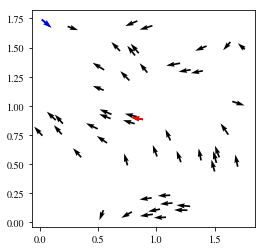

In [329]:
#Before rotation
tester = 40
X_DMD, _ = recentre_milling(X_DMD,X_DMD,(L/2)-X_DMD[focal,t],(L/2)-X_DMD[N+focal,t])
plt.quiver(X_DMD[:N,t],X_DMD[N:,t],X_DMD_dot[:N,t],X_DMD_dot[N:,t])
plt.quiver(X_DMD[focal,t],X_DMD[N+focal,t],X_DMD_dot[focal,t],X_DMD_dot[N+focal,t],color='r')
plt.quiver(X_DMD[tester,t],X_DMD[N+tester,t],X_DMD_dot[tester,t],X_DMD_dot[N+tester,t],color='b')
plt.xlim(0, L)
plt.ylim(0, L)
plt.axis('scaled')

(-0.040094542171486544,
 1.7968463752771402,
 0.0021005794205037204,
 1.7921596907558797)

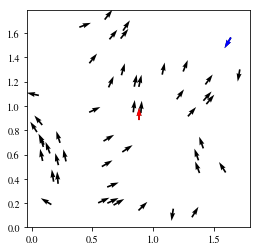

In [330]:
# After rotation
tester = 40
plt.quiver(X_rot[:N],X_rot[N:],np.cos(heading_rot),np.sin(heading_rot))
plt.quiver(X_rot[focal],X_rot[N+focal],np.cos(heading_rot[focal]),np.sin(heading_rot[focal]),color='r')
plt.quiver(X_rot[tester],X_rot[N+tester],np.cos(heading_rot[tester]),np.sin(heading_rot[tester]),color='b')
plt.xlim(0, L)
plt.ylim(0, L)
plt.axis('scaled')

In [272]:
list(set(np.where(X_rot[N:]<0.8)[0].tolist()).intersection(np.where(X_rot[N:]>0.7)[0].tolist()))

[40, 25, 30]

In [290]:
interagent_rot-interagent[:,:,t]

array([[ 0.00000000e+00, -1.11022302e-16, -1.11022302e-16, ...,
        -3.91671646e-01, -2.75468033e-03, -1.11022302e-16],
       [-1.11022302e-16,  0.00000000e+00,  2.43012696e-03, ...,
        -3.94402994e-01, -2.42813507e-01, -1.11022302e-16],
       [-1.11022302e-16,  2.43012696e-03,  0.00000000e+00, ...,
        -2.22044605e-16, -1.11022302e-16, -1.11022302e-16],
       ...,
       [-3.91671646e-01, -3.94402994e-01, -2.22044605e-16, ...,
         0.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [-2.75468033e-03, -2.42813507e-01, -1.11022302e-16, ...,
         2.22044605e-16,  0.00000000e+00,  0.00000000e+00],
       [-1.11022302e-16, -1.11022302e-16, -1.11022302e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

50